In [ ]:
! pip install -q bing-image-downloader
! pip install -q dlib
! pip install -q cv2
! pip install -q imutils
! pip install websockets==13.1
! pip install libmagic
! pip install supervisely
! pip install kaggle
# brew install libmagic


^C
ERROR: Operation cancelled by user


In [1]:
from bing_image_downloader import downloader
import wget
import os
import glob
import matplotlib.pyplot as plt
from imutils import face_utils
import pandas as pd
import numpy as np
import cv2
import dlib
import supervisely as sly


# 1. Базовая работа с python/numpy

Скачайте 10-20 изображений с лицами из интернета какими удобно средствами (например)

Воспользуйтесь одним из готовых face-detector/face-landmark-detector для того, чтобы на выбранных изображениях найти лицо и ключевые точки на лице. Можно для этого взять связку библиотек OpenCV (opencv-python) & dlib (dlib-python). Результат детектирования лица (bbox) & landmarks (points) визуализировать в jupyter-notebook для первых 5-10 картинок.
 
Для визуализации можно использовать matplotlib, например 🕷️


## Скачивание изображений

In [2]:
def download_images(query, limit=20, output_dir='downloaded_images'):
    downloader.download(query, limit=limit, output_dir=output_dir, 
                       adult_filter_off=False, force_replace=False, timeout=60)
    
    # Формируем список путей к скачанным изображениям
    image_dir = os.path.join(output_dir, query)
    images = glob.glob(os.path.join(image_dir, "*.jpg")) + \
             glob.glob(os.path.join(image_dir, "*.jpeg")) + \
             glob.glob(os.path.join(image_dir, "*.png"))
    
    return images[:limit]

# Пример использования
image_paths = download_images("human faces portrait", limit=10)


[%] Downloading Images to /Users/rvenie/Desktop/datahub/downloaded_images/human faces portrait


[!!]Indexing page: 1

[%] Indexed 10 Images on Page 1.


[%] Downloading Image #1 from https://i.pinimg.com/originals/3a/25/d4/3a25d4c633cf0b4b8bb3af3adb91d9a4.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://i.pinimg.com/originals/8c/fd/c1/8cfdc1f8149727312aa77ca580c00b59.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://i.pinimg.com/originals/e0/3c/26/e03c26f07bfb6ef6c15ec7b0171df145.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://cdn.domestika.org/c_fill,dpr_auto,f_auto,q_auto/v1671618273/content-items/012/857/042/1_Portrait-sketchbooking%2520Crop-original.jpg?1671618273
[%] File Downloaded !

[%] Downloading Image #5 from https://parrotprint.com/wp/wp-content/uploads/2017/04/pexels-photo-27411.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://i.pinimg.com/originals/ef/9a/59/ef9a59197f427ea5d9d53c9a37182065.jpg
[%] File Downl

## Импорт моделей

In [3]:
# Скачивание предобученной модели, если она отсутствует
if not os.path.exists('shape_predictor_68_face_landmarks.dat'):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    wget.download(url)
    # Распаковка bz2 архива
    import bz2
    with bz2.BZ2File('shape_predictor_68_face_landmarks.dat.bz2') as f:
        data = f.read()
    with open('shape_predictor_68_face_landmarks.dat', 'wb') as f:
        f.write(data)


# Модель детекции лица
face_detector = dlib.get_frontal_face_detector()

# Модель определения ключевых точек
model_landmark = 'shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_landmark)


## Функции детекции лица и точек

In [4]:
def detect_faces_and_landmarks(image_input, use_file_path=True):
    # Определяем изображение в зависимости от типа входного параметра
    if use_file_path:
        # Загружаем изображение из файла
        image = cv2.imread(image_input)
        if image is None:
            print(f"Could not read image: {image_input}")
            return None, [], []
    else:
        # Используем переданный массив
        image = image_input.copy()
        
        # Проверяем, является ли изображение одноканальным
        if len(image.shape) == 2:
            # Преобразуем в трехканальное изображение для совместимости с CV2
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Преобразование в оттенки серого для детектирования
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Обнаружение лиц
    faces = face_detector(gray, 1)
    
    # Список прямоугольников лиц (x, y, w, h)
    face_rects = []
    
    # Список ключевых точек для каждого лица
    landmarks_list = []
    
    # Для каждого обнаруженного лица
    for face in faces:
        # Получаем координаты прямоугольника лица
        x = face.left()
        y = face.top()
        w = face.right() - x
        h = face.bottom() - y
        face_rects.append((x, y, w, h))
        
        # Определяем ключевые точки
        landmarks = landmark_predictor(gray, face)
        
        # Преобразуем ключевые точки в numpy массив
        landmarks = face_utils.shape_to_np(landmarks)
        landmarks_list.append(landmarks)
    
    # Преобразуем изображение из BGR в RGB для корректного отображения в matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image_rgb, face_rects, landmarks_list


def visualize_detection(image: np.ndarray, face_rects: list, landmarks_list: list) -> None:
    # Создаем копию изображения для рисования
    image_with_landmarks = image.copy()
    
    # Рисуем прямоугольники вокруг лиц
    if face_rects: 
        for (x, y, w, h) in face_rects:
            cv2.rectangle(image_with_landmarks, (x, y), (x + w, y + h), (0, 255, 0), 3)
    
    # Рисуем ключевые точки
    for landmarks in landmarks_list:
        for (x, y) in landmarks:
            cv2.circle(image_with_landmarks, (x, y), 3, (0, 0, 255), -1)
    
    # Отображаем изображение с помощью matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_landmarks)
    plt.axis('off')
    plt.title(f'Обнаружено лиц: {len(face_rects)}')
    plt.show()

## Визуализация

Обработка изображения 1: downloaded_images/human faces portrait/Image_8.jpg


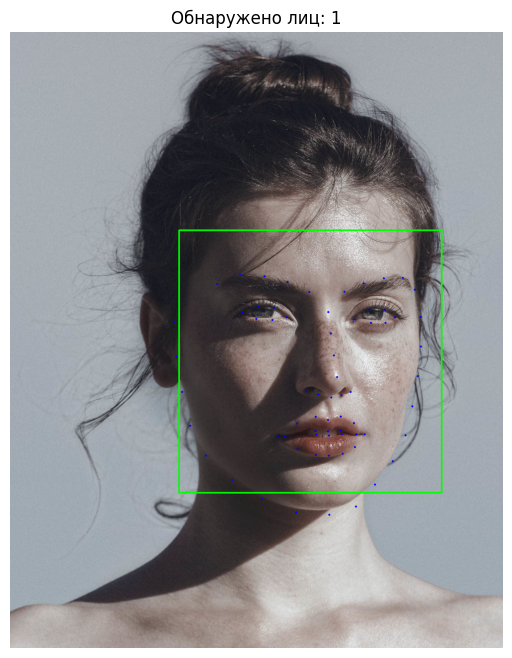

Обработка изображения 2: downloaded_images/human faces portrait/Image_9.jpg


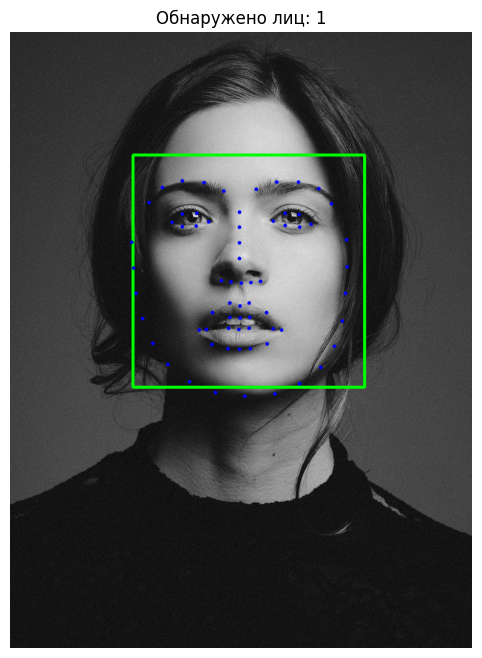

Обработка изображения 3: downloaded_images/human faces portrait/Image_2.jpg


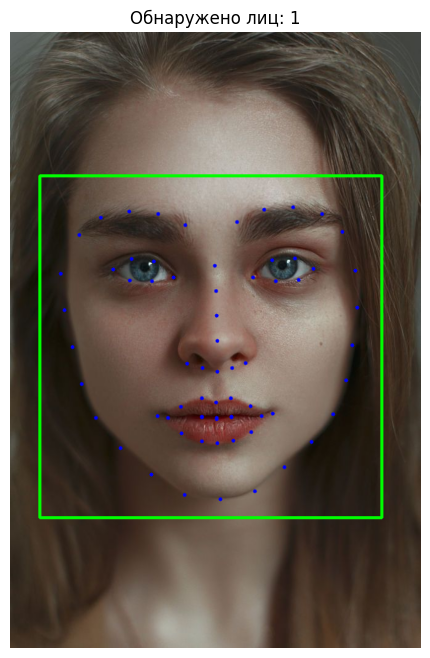

Обработка изображения 4: downloaded_images/human faces portrait/Image_3.jpg


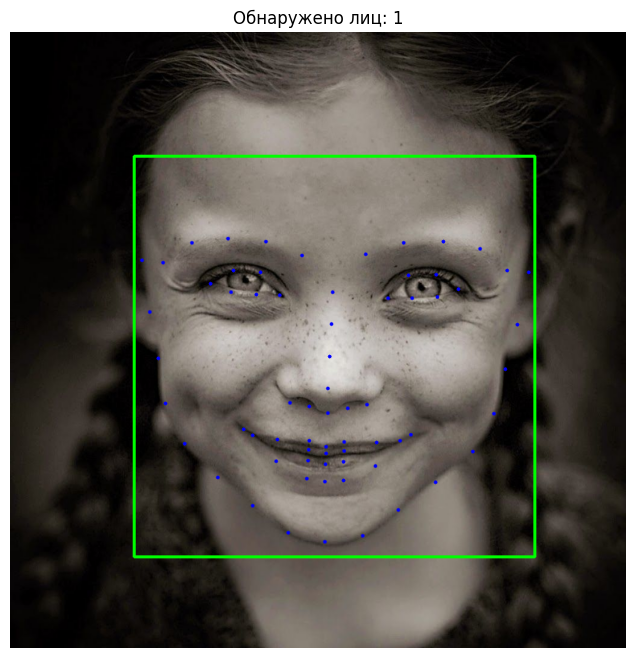

Обработка изображения 5: downloaded_images/human faces portrait/Image_1.jpg


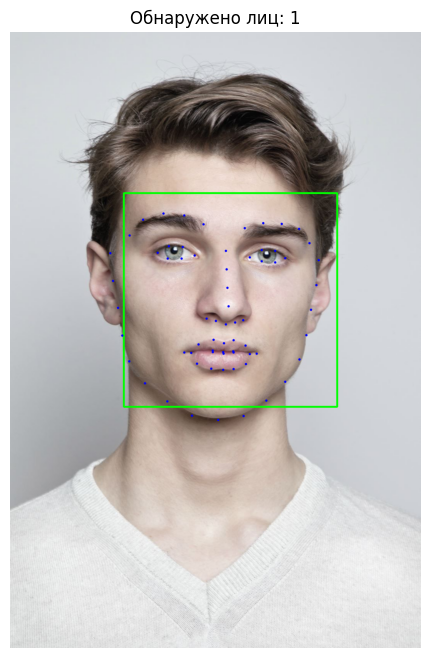

In [5]:
data = []
for i, image_path in enumerate(image_paths[:5]):
    print(f"Обработка изображения {i+1}: {image_path}")
    
    # Детектирование лиц и ключевых точек
    image, face_rects, landmarks_list = detect_faces_and_landmarks(image_path)
    # Для каждого обнаруженного лица
    for i, (bbox, landmarks) in enumerate(zip(face_rects, landmarks_list)):
        # Преобразуем данные в удобный формат
        record = {
            "image_path": image_path,
            "face_number": i + 1,
            "bbox_x": bbox[0],
            "bbox_y": bbox[1],
            "bbox_width": bbox[2],
            "bbox_height": bbox[3],
            "landmarks_x": list(landmarks[:, 0].astype(int)),
            "landmarks_y": list(landmarks[:, 1].astype(int))
        }
        data.append(record)
    if image is not None:
        # Визуализация результатов
        visualize_detection(image, face_rects, landmarks_list)
    else:
        print(f"Пропущено изображение {image_path}")

if data:
    pd.DataFrame(data).to_csv('bing_face_data.csv', index=False, encoding='utf-8')

# 2. Оценка метрик и валидация моделей

Задетектируйте при помощи выбранного выше landmark-детектора точки на лицах из этого датасета и посчитайте метрики для Ground-Truth точек которые эквивалентны точкам из модели (в opencv 68-point модель, в kaggle разметка для 15-точек.

Подумайте, предложите метрики, которые стоит посчитать для этой задачи. Мы хотим при помощи этих метрик оценить несколько факторов:
оценить точность детектирования каждой из точек и всех точек в среднем
оценить точность позиционирования (насколько точки смещаются относительно GT) для каждой landmark и в среднем
Отберите и визуализируйте (изображение + точки Ground Truth + Predicts) 3-5 изображений с самым высоким качеством детектирования и с самым низким.


## Скачайте датасет с kaggle-соревнования Kaggle: Facial Keypoints Detection

In [6]:
#! kaggle competitions download -c facial-keypoints-detection
#! unzip facial-keypoints-detection.zip -d facial_keypoints
! unzip facial_keypoints/test.zip -d facial_keypoints
! unzip facial_keypoints/training.zip -d facial_keypoints


unzip:  cannot find or open facial_keypoints/test.zip, facial_keypoints/test.zip.zip or facial_keypoints/test.zip.ZIP.
unzip:  cannot find or open facial_keypoints/training.zip, facial_keypoints/training.zip.zip or facial_keypoints/training.zip.ZIP.


## Задетектируйте при помощи выбранного выше landmark-детектора точки на лицах из этого датасета и 

### Dlib

In [7]:
# Загрузка данных
train_df = pd.read_csv('facial_keypoints/training.csv')

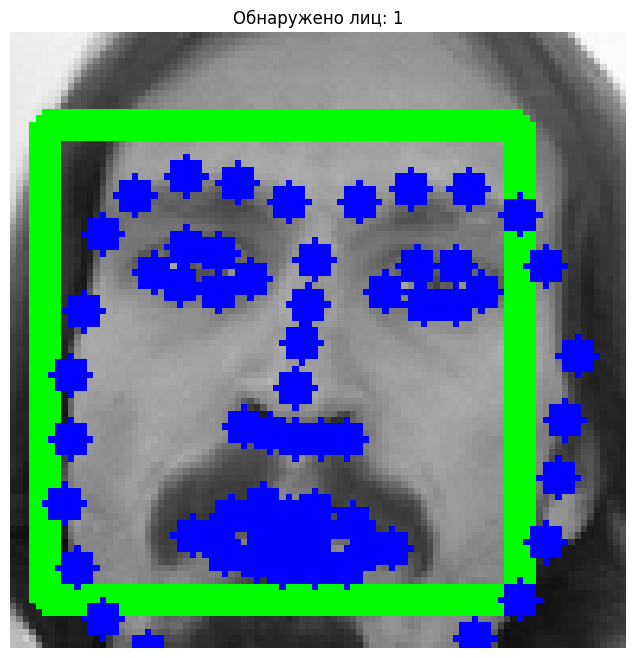

In [8]:
# Функция преобразования строки в изображение
def string_to_image(image_string):
    return np.array([int(pixel) for pixel in image_string.split()], 
                   dtype=np.uint8).reshape(96, 96)

image, face_rects, landmarks_list = detect_faces_and_landmarks(string_to_image(train_df['Image'][0]), use_file_path=False)
visualize_detection(image, face_rects, landmarks_list)


### Ground Truth

Пропущенные значения: 0


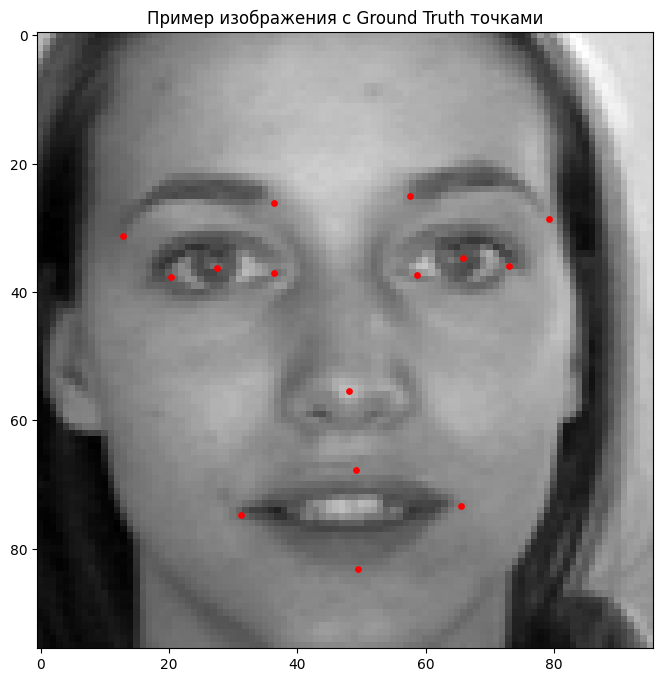

In [9]:
image_num = 8

# Извлечение только координат для ключевых точек
x_cols = [col for col in train_df.columns if '_x' in col]
y_cols = [col for col in train_df.columns if '_y' in col]

# Получаем значения координат для первого изображения
x_values = train_df.iloc[image_num][x_cols].values
y_values = train_df.iloc[image_num][y_cols].values
gt_points = np.column_stack((x_values, y_values))
print("Пропущенные значения:", train_df.iloc[0].isnull().sum())

# Отображаем изображение с ключевыми точками
plt.figure(figsize=(8, 8))
plt.imshow(string_to_image(train_df['Image'][image_num]), cmap='gray')
plt.scatter(x_values, y_values, c='r', s=15)
plt.title('Пример изображения с Ground Truth точками')
plt.show()

![Screenshot 2025-03-31 at 13.36.27.png](<attachment:Screenshot 2025-03-31 at 13.36.27.png>)
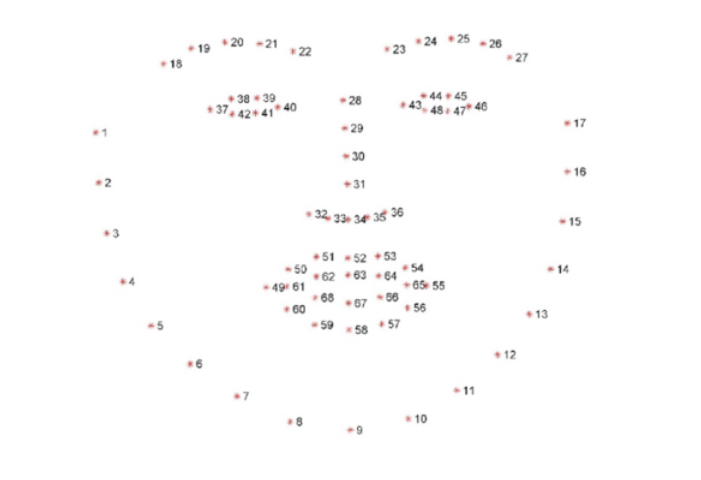

In [10]:
# Соответствие между 15 точками Kaggle и 68 точками dlib 0-67. Фотография выше не совсем соответствует реальным точкам, цифры подобраны эмпирическим путем
MAPPING = {
    'left_eye_center': 43,        # Левый глаз с точки зрения камеры
    'right_eye_center': 37,       # Правый глаз с точки зрения камеры
    'left_eye_inner_corner': 42,  # Внутренний угол левого глаза
    'left_eye_outer_corner': 45,  # Внешний угол левого глаза
    'right_eye_inner_corner': 39, # Внутренний угол правого глаза
    'right_eye_outer_corner': 36, # Внешний угол правого глаза
    'left_eyebrow_inner_end': 22, # Внутренний конец левой брови
    'left_eyebrow_outer_end': 26, # Внешний конец левой брови
    'right_eyebrow_inner_end': 21,# Внутренний конец правой брови
    'right_eyebrow_outer_end': 17,# Внешний конец правой брови
    'nose_tip': 30,               # Кончик носа
    'mouth_left_corner': 54,      # Левый уголок рта
    'mouth_right_corner': 48,     # Правый уголок рта
    'mouth_center_top_lip': 51,   # Центр верхней губы
    'mouth_center_bottom_lip': 57 # Центр нижней губы
}


### Сопоставление точек

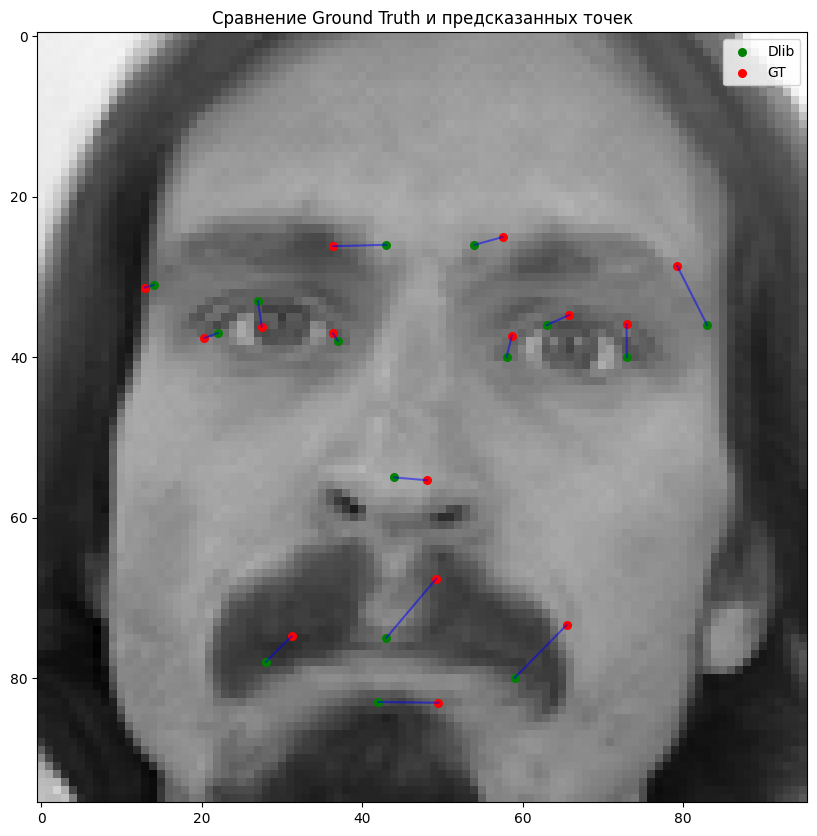

In [11]:
def detect_landmarks(image):
    # Преобразование в RGB для dlib
    if len(image.shape) == 2:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image
    
    # Детекция лиц
    faces = face_detector(image_rgb, 1)
    if not faces:
        return None
    
    # Детекция ключевых точек
    landmarks = landmark_predictor(image_rgb, faces[0])
    
    # Получаем размеры текущего изображения
    h, w = image_rgb.shape[:2]
    
    # Получаем точки в оригинальном масштабе
    points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in MAPPING.values()])
    
    # Масштабируем к формату 96x96
    points[:, 0] = points[:, 0] * 96 / w
    points[:, 1] = points[:, 1] * 96 / h
    
    return points

# Теперь для визуализации:
sample_image = string_to_image(train_df['Image'][0])
pred_points = detect_landmarks(sample_image)

plt.figure(figsize=(10, 10))
plt.imshow(sample_image, cmap='gray')
plt.scatter(pred_points[:,0], pred_points[:,1], c='g', s=30, label='Dlib')
plt.scatter(x_values, y_values, c='r', s=30, label='GT')

# Соединяем соответствующие точки для наглядности
for i, (key, idx) in enumerate(MAPPING.items()):
    if i < len(x_values):  # Защита от выхода за границы
        plt.plot([pred_points[i,0], x_values[i]], 
                [pred_points[i,1], y_values[i]], 'b-', alpha=0.5)

plt.legend()
plt.title('Сравнение Ground Truth и предсказанных точек')
plt.show()


## Оценить точность детектирования и позиционирования для каждой landmark и в среднем

> Метрики для оценки точности позицинирования:
- Mean Absolute Error (MAE) - средняя абсолютная ошибка в пикселях
- Root Mean Square Error (RMSE) - корень из среднеквадратичной ошибки(больший вес большим ошибкам)
- Normalized Mean Error (NME) - ошибка, нормализованная относительно размера изображения(ошибка в 5 пикселей на большом изображении менее критична, чем на маленьком)


> Метрики для оценки точности детектирования:
- Success Rate - процент точек, определенных с ошибкой меньше порогового значения(10% от диагонали)

> Доп. аналитика
- Per Point Error - хранение ошибки каждой точки для детального анализа
- Error Percentiles - для визуализации процента распределения ошибок 
- Bias - есть ли у алгоритма тенденция смещать точки в определенном направлении 
- Считтаем региональную ошибку по MAE и RSME для каждого региона

### Определение метрик

У модели dlib отсутствуют точки позиционирования зрачков глаз. Межзрачковое расстояние для нормализации использовать не получится

In [12]:
def calculate_metrics(gt_points, pred_points) -> dict:
    # Проверяем, что размеры массивов совпадают
    assert gt_points.shape == pred_points.shape, "Размеры GT и Pred должны совпадать"
    
    # Вычисляем евклидово расстояние для каждой точки
    diff = gt_points - pred_points
    squared_diff = diff * diff
    sum_squared_diff = np.sum(squared_diff, axis=1)
    point_errors = sum_squared_diff ** 0.5
    
    # Нормализующий фактор (диагональ изображения, размер 96x96)
    norm_factor = np.sqrt(96**2 + 96**2)

    # Доля точек с ошибкой меньше порога (например, 10% от диагонали)
    threshold = 0.1 * norm_factor

    # Основные метрики
    metrics = {
        'MAE': np.mean(point_errors[2:]),   # Исключил центр глаз из рассчета, чтобы быть опираться на точно совпадающие точки 
        'RMSE': np.sqrt(np.mean(point_errors[2:]**2)),  
        'NME': np.mean(point_errors[2:]) / norm_factor,  
        'Per_Point_Error': {i: error for i, error in enumerate(point_errors[2:])},
        'Success_Rate': np.mean(point_errors[2:] < threshold),
        'Error_Percentiles': [np.percentile(point_errors[2:], p) for p in range(0, 101, 5)],
        'Bias': {'x': np.mean(diff[:, 0]), 'y': np.mean(diff[:, 1])}
    }

    # Индексы групп точек в массиве point_errors
    # Соответствуют порядку точек в MAPPING
    regions = {
        'eyes': [2, 3, 4, 5],  # Уголки глаз (без центров)
        'eyebrows': [6, 7, 8, 9],  # Брови
        'nose': [10],  # Кончик носа
        'mouth': [11, 12, 13, 14]  # Рот
    }
    
    # Считаем ошибки по регионам
    metrics['Region_Error'] = {}
    for region_name, region_indices in regions.items():
        region_errors = point_errors[region_indices]
        metrics['Region_Error'][region_name] = {
            'MAE': np.mean(region_errors),
            'RMSE': np.sqrt(np.mean(region_errors**2))
        }
    
    return metrics


### Рассчет

In [13]:
from tqdm import tqdm 

# Список для хранения результатов
results = []

# Обрабатываем изображения (ограничимся 100 для примера)
for i in tqdm(range(min(1000, len(train_df)))):
    # Пропускаем изображения с NaN
    if train_df.iloc[i][x_cols + y_cols].isnull().values.any():
        continue
    gt_points = np.array(gt_points, dtype=np.float64)
    pred_points = np.array(pred_points, dtype=np.float64)

    # Получаем изображение и GT-точки
    image = string_to_image(train_df['Image'][i])
    x_values = train_df.iloc[i][x_cols].values
    y_values = train_df.iloc[i][y_cols].values
    gt_points = np.column_stack((x_values, y_values))
    
    # Детектируем точки
    pred_points = detect_landmarks(image)
    if pred_points is None:
        continue
    
    # Рассчитываем метрики
    metrics = calculate_metrics(gt_points, pred_points)
    
    # Сохраняем результаты
    results.append({
        'index': i,
        'image': image,
        'gt_points': gt_points,
        'pred_points': pred_points,
        'metrics': metrics
    })

# Сортируем результаты по MAE
results_sorted = sorted(results, key=lambda x: x['metrics']['MAE']) # это среднее отклонение в пикселях


Processing: 100%|██████████| 1000/1000 [00:07<00:00, 128.25it/s]


### Визуализация

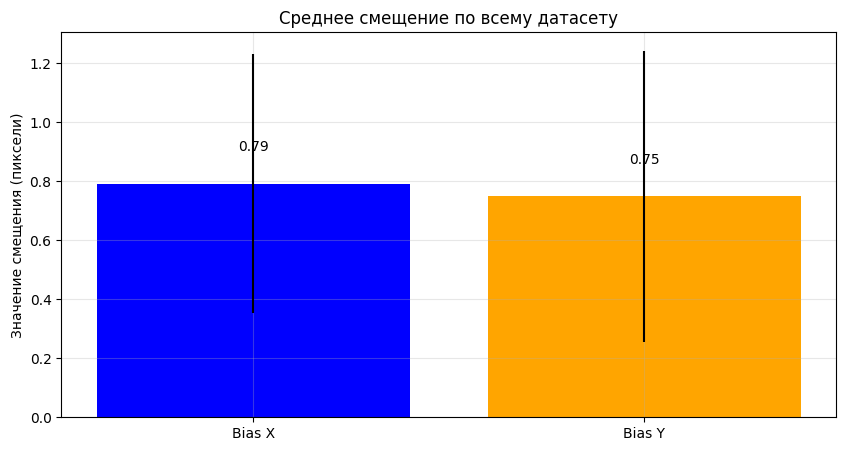

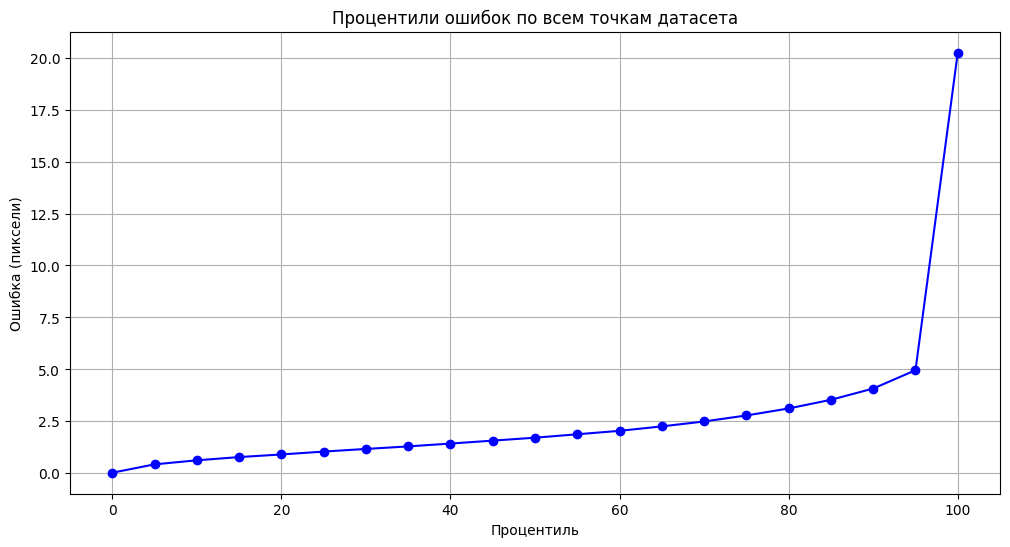

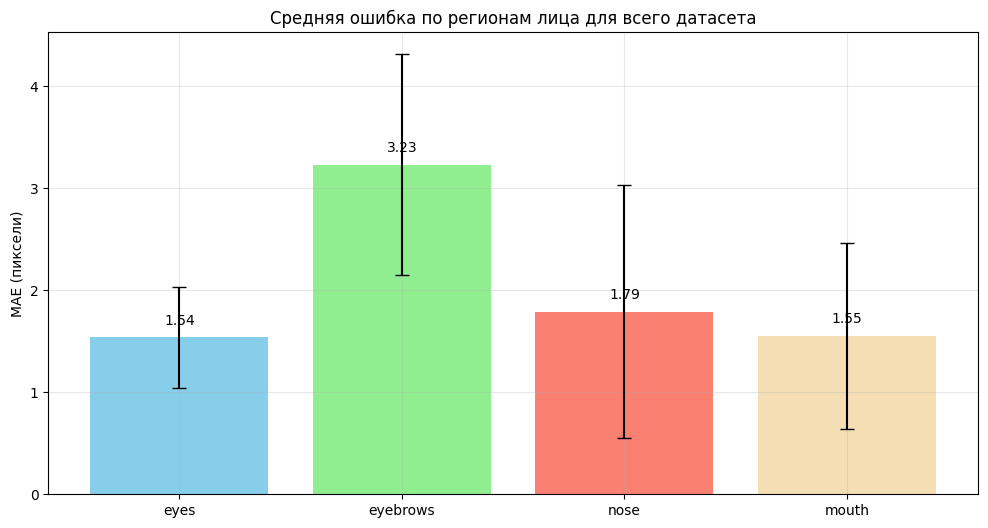

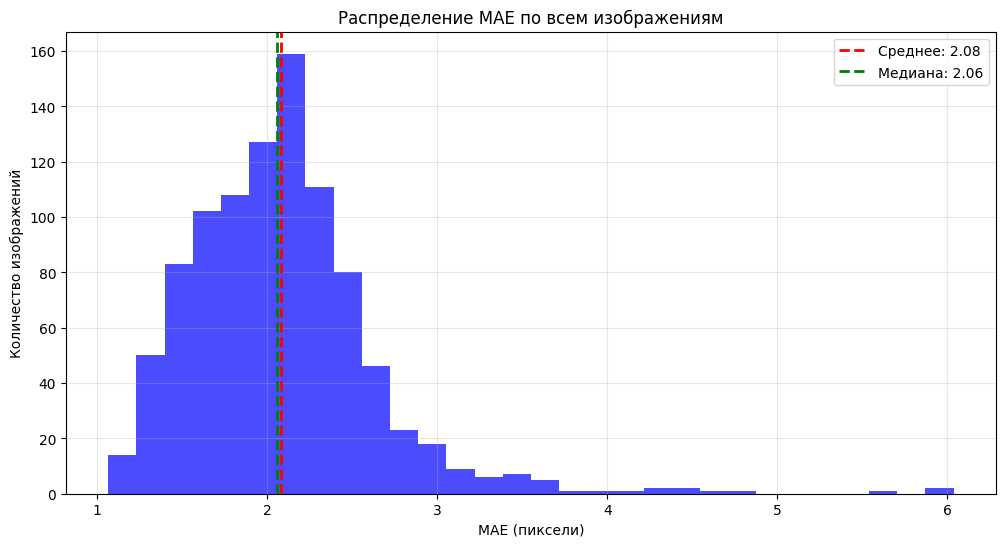

===== Статистика по датасету =====
Количество изображений: 960
Средняя MAE: 2.0813 ± 0.5500
Средняя RMSE: 2.4648 ± 0.6920
Медиана MAE: 2.0563
Медиана RMSE: 2.4056
Смещение X: 0.7923 ± 0.4394
Смещение Y: 0.7496 ± 0.4940


In [14]:
def visualize_dataset_metrics(results):
    """
    Функция для визуализации агрегированных метрик по всему датасету
    """
    # Сбор метрик со всех изображений
    all_mae = [r['metrics']['MAE'] for r in results]
    all_rmse = [r['metrics']['RMSE'] for r in results]
    all_bias_x = [r['metrics']['Bias']['x'] for r in results]
    all_bias_y = [r['metrics']['Bias']['y'] for r in results]
    
    # Сбор ошибок по точкам для процентильного анализа
    all_point_errors = []
    for r in results:
        for point_idx, error in r['metrics']['Per_Point_Error'].items():
            all_point_errors.append(error)
    
    # Сбор ошибок по регионам
    region_errors = {}
    for r in results:
        if 'Region_Error' in r['metrics']:
            for region, metrics in r['metrics']['Region_Error'].items():
                if region not in region_errors:
                    region_errors[region] = {'MAE': [], 'RMSE': []}
                region_errors[region]['MAE'].append(metrics['MAE'])
                region_errors[region]['RMSE'].append(metrics['RMSE'])
    
    # 1. Визуализация усреднённого смещения (bias)
    plt.figure(figsize=(10, 5))
    mean_bias_x, mean_bias_y = np.mean(all_bias_x), np.mean(all_bias_y)
    std_bias_x, std_bias_y = np.std(all_bias_x), np.std(all_bias_y)
    
    bars = plt.bar(['Bias X', 'Bias Y'], [mean_bias_x, mean_bias_y], 
            color=['blue', 'orange'], yerr=[std_bias_x, std_bias_y])
    
    # Добавление значений над столбцами
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height > 0 else -0.1),
                f'{height:.2f}',
                ha='center', va='bottom' if height > 0 else 'top')
    
    plt.title("Среднее смещение по всему датасету")
    plt.ylabel('Значение смещения (пиксели)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 2. Визуализация процентилей ошибок по всему датасету
    percentiles = range(0, 101, 5)
    dataset_percentiles = [np.percentile(all_point_errors, p) for p in percentiles]
    
    plt.figure(figsize=(12, 6))
    plt.plot(percentiles, dataset_percentiles, marker='o', linestyle='-', color='blue')
    plt.title("Процентили ошибок по всем точкам датасета")
    plt.xlabel('Процентиль')
    plt.ylabel('Ошибка (пиксели)')
    plt.grid(True)
    plt.show()
    
    # 3. Визуализация ошибок по регионам
    if region_errors:
        regions = list(region_errors.keys())
        mean_mae_values = [np.mean(region_errors[r]['MAE']) for r in regions]
        std_mae_values = [np.std(region_errors[r]['MAE']) for r in regions]
        
        plt.figure(figsize=(12, 6))
        bars = plt.bar(regions, mean_mae_values, color=['skyblue', 'lightgreen', 'salmon', 'wheat'],
                      yerr=std_mae_values, capsize=5)
        
        # Добавление значений над столбцами
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.2f}',
                    ha='center', va='bottom')
            
        plt.title("Средняя ошибка по регионам лица для всего датасета")
        plt.ylabel('MAE (пиксели)')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # 4. Гистограмма распределения ошибок MAE по изображениям
    plt.figure(figsize=(12, 6))
    plt.hist(all_mae, bins=30, alpha=0.7, color='blue')
    plt.axvline(np.mean(all_mae), color='red', linestyle='dashed', linewidth=2, 
                label=f'Среднее: {np.mean(all_mae):.2f}')
    plt.axvline(np.median(all_mae), color='green', linestyle='dashed', linewidth=2, 
                label=f'Медиана: {np.median(all_mae):.2f}')
    plt.title("Распределение MAE по всем изображениям")
    plt.xlabel("MAE (пиксели)")
    plt.ylabel("Количество изображений")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 5. Статистика по всем метрикам
    print(f"===== Статистика по датасету =====")
    print(f"Количество изображений: {len(results)}")
    print(f"Средняя MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
    print(f"Средняя RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
    print(f"Медиана MAE: {np.median(all_mae):.4f}")
    print(f"Медиана RMSE: {np.median(all_rmse):.4f}")
    print(f"Смещение X: {mean_bias_x:.4f} ± {std_bias_x:.4f}")
    print(f"Смещение Y: {mean_bias_y:.4f} ± {std_bias_y:.4f}")
visualize_dataset_metrics(results)

=== Лучшие результаты детектирования ===


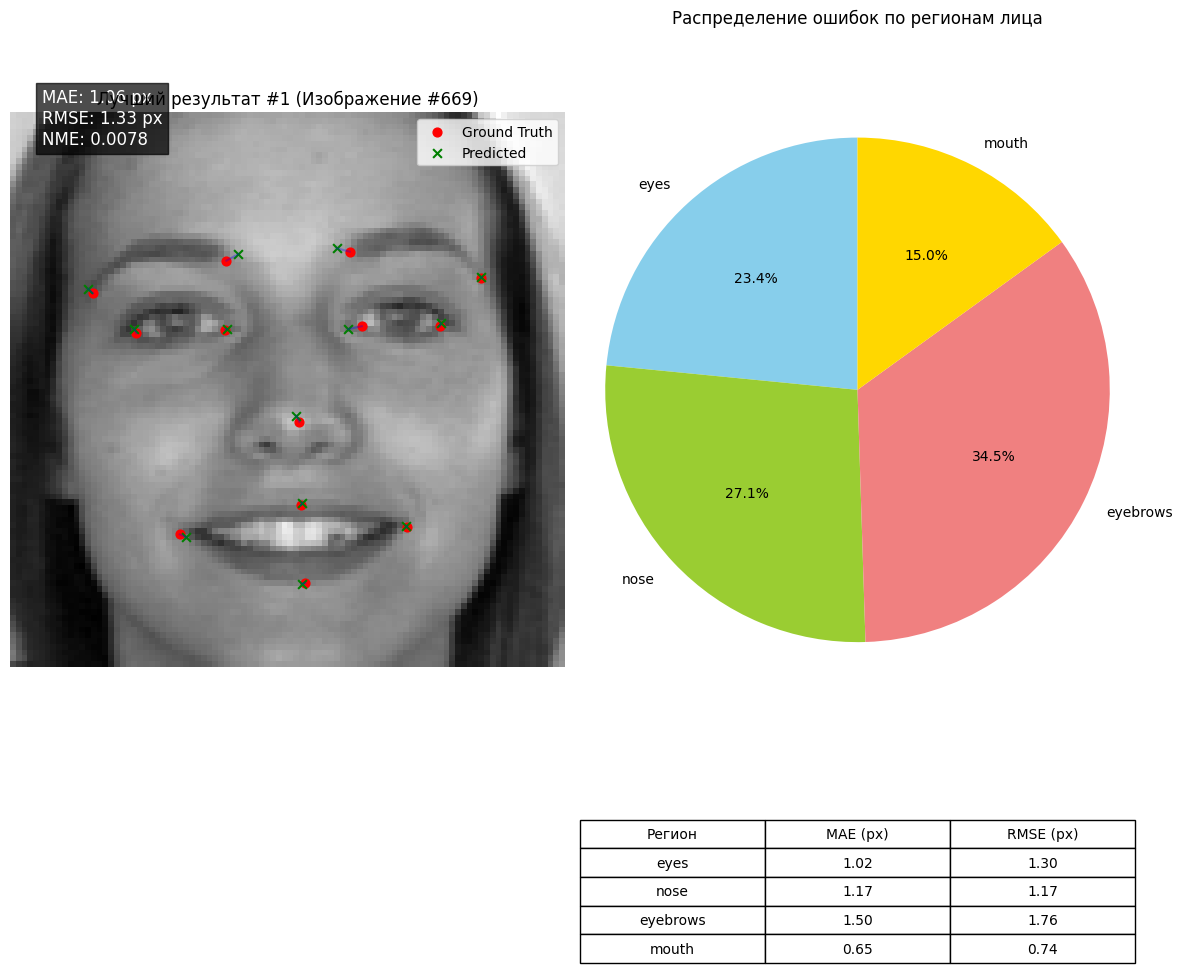

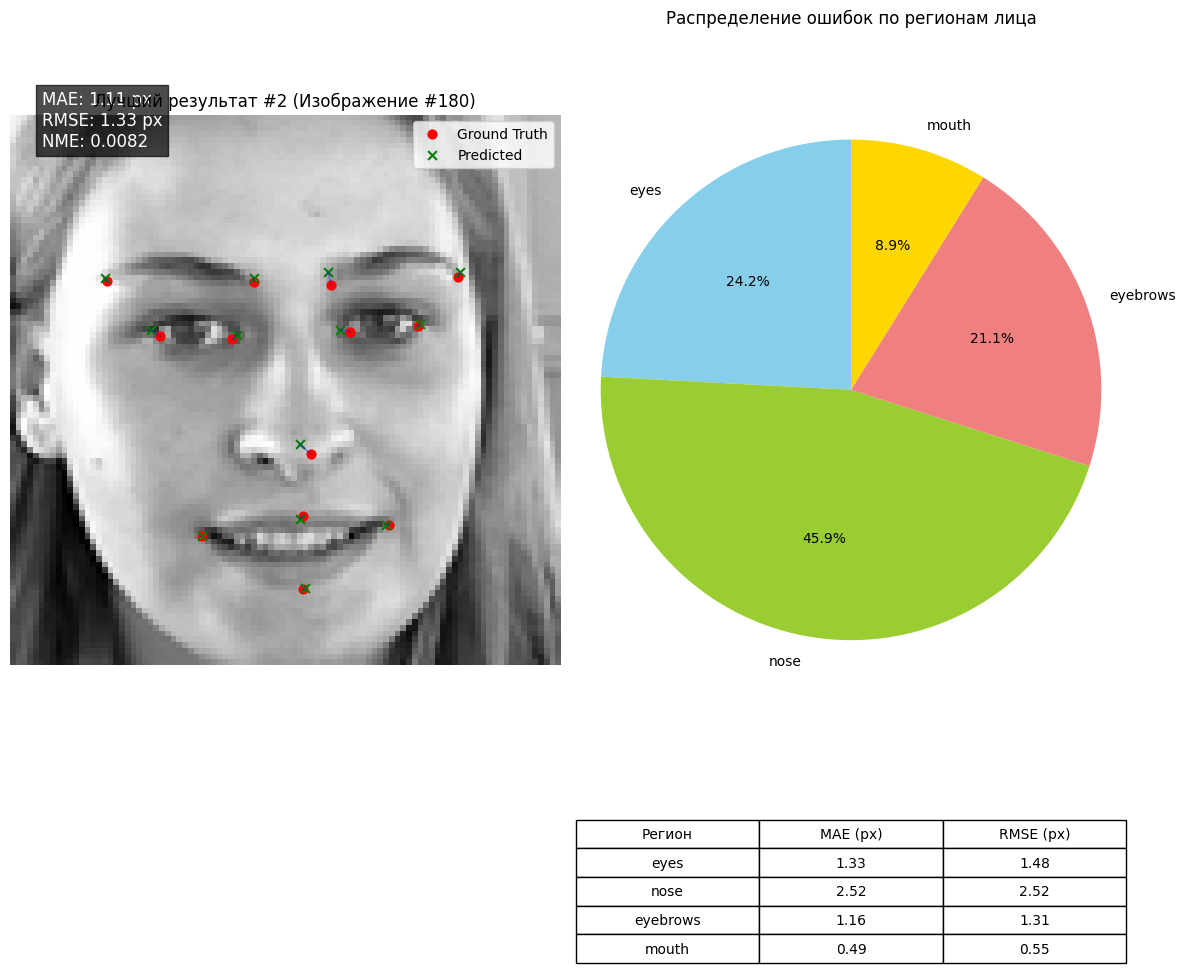

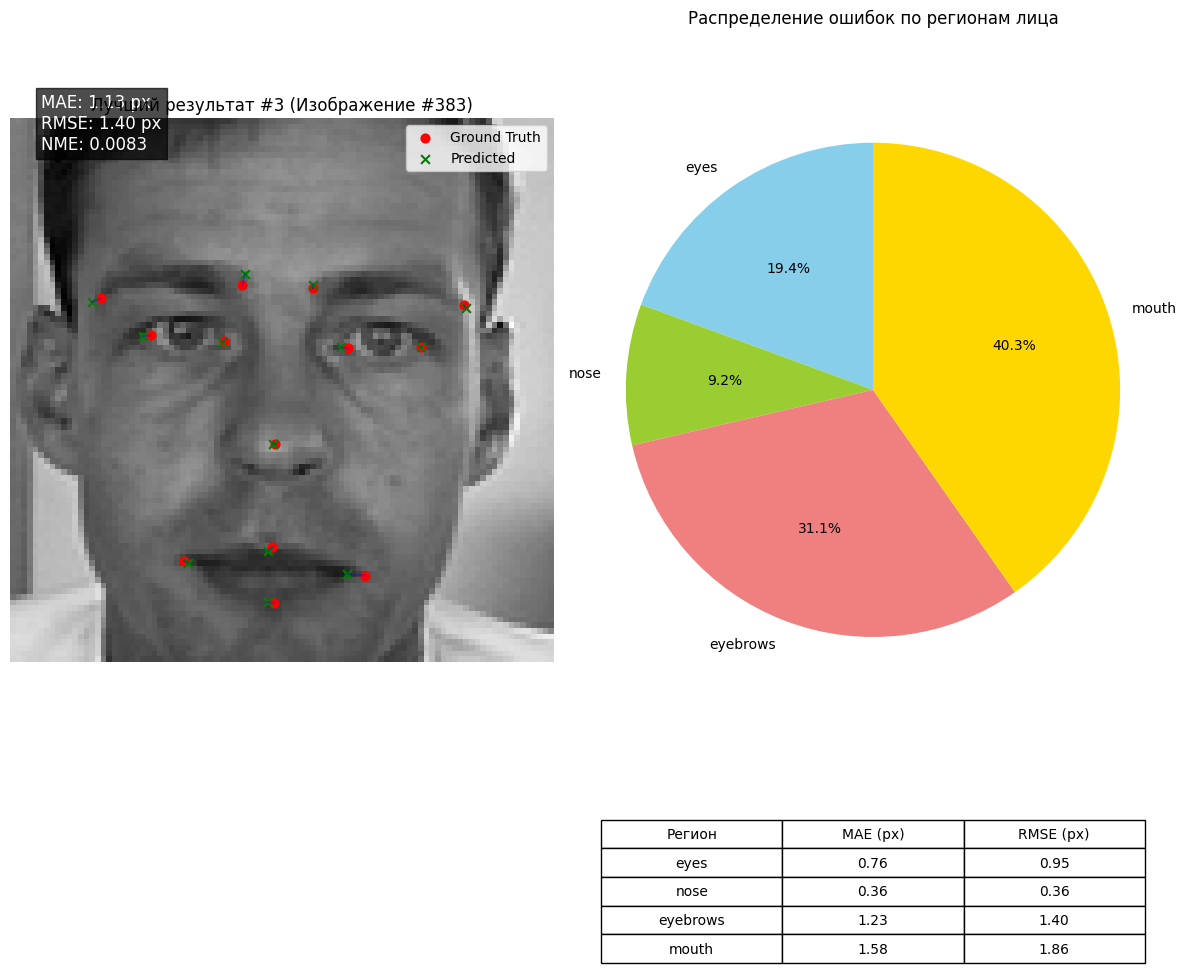

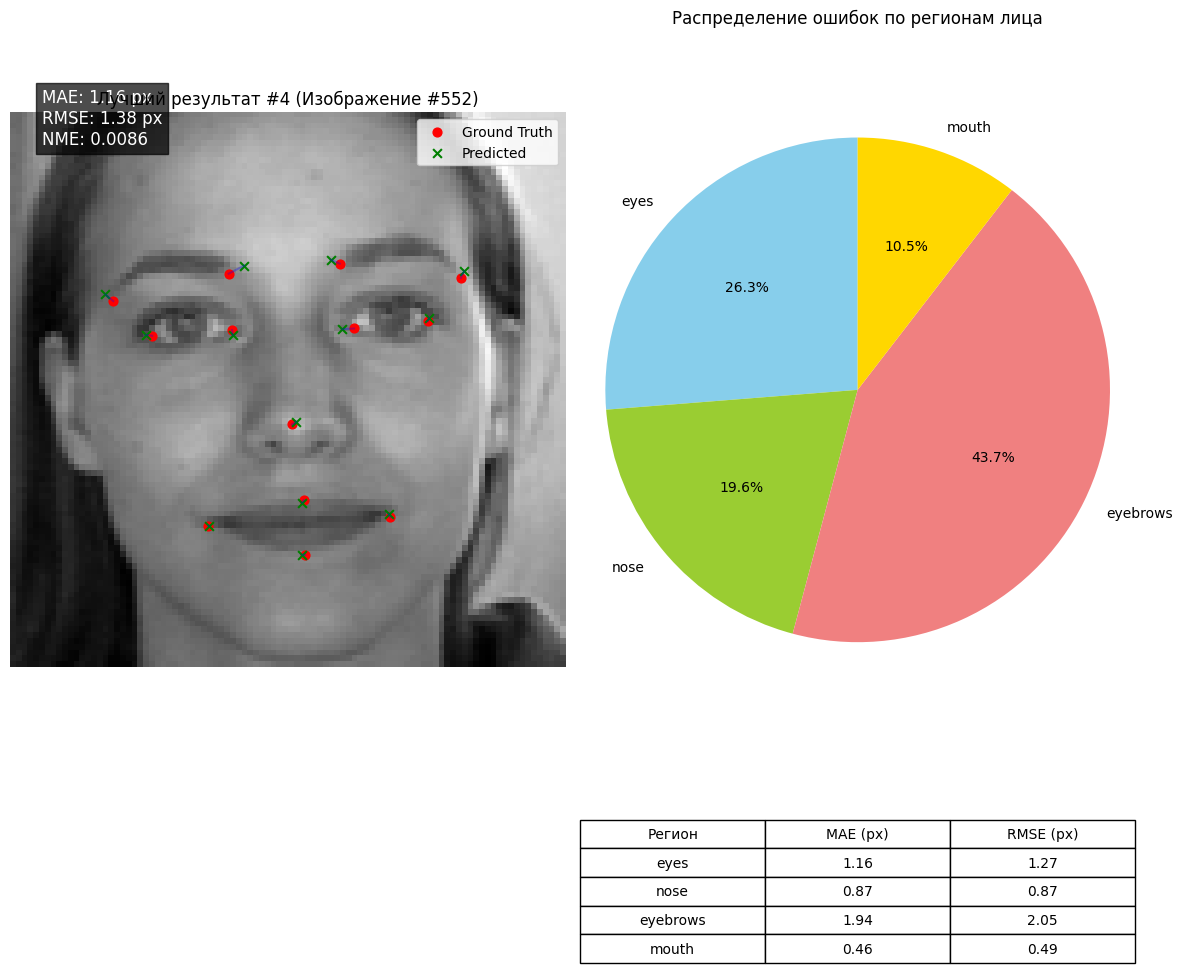

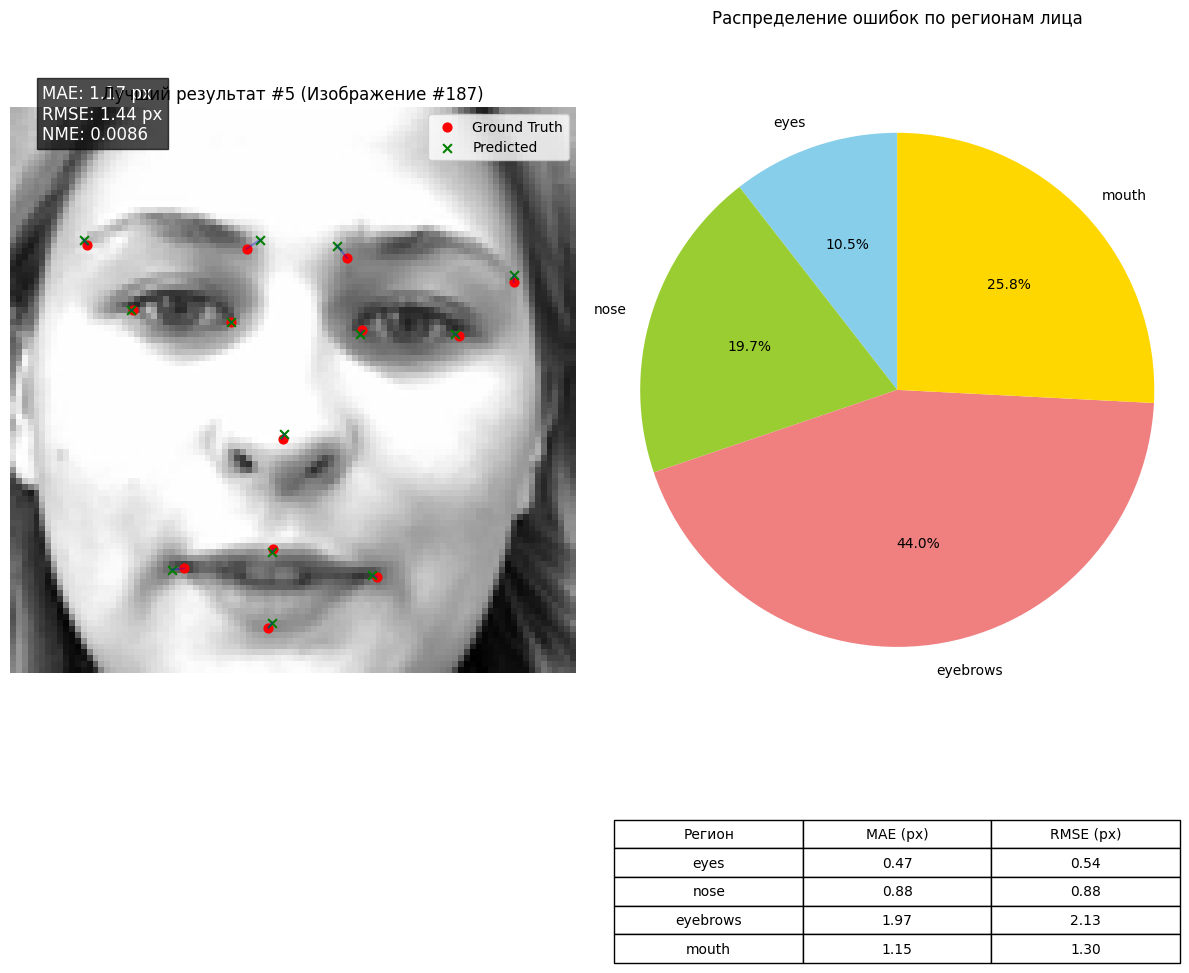


=== Худшие результаты детектирования ===


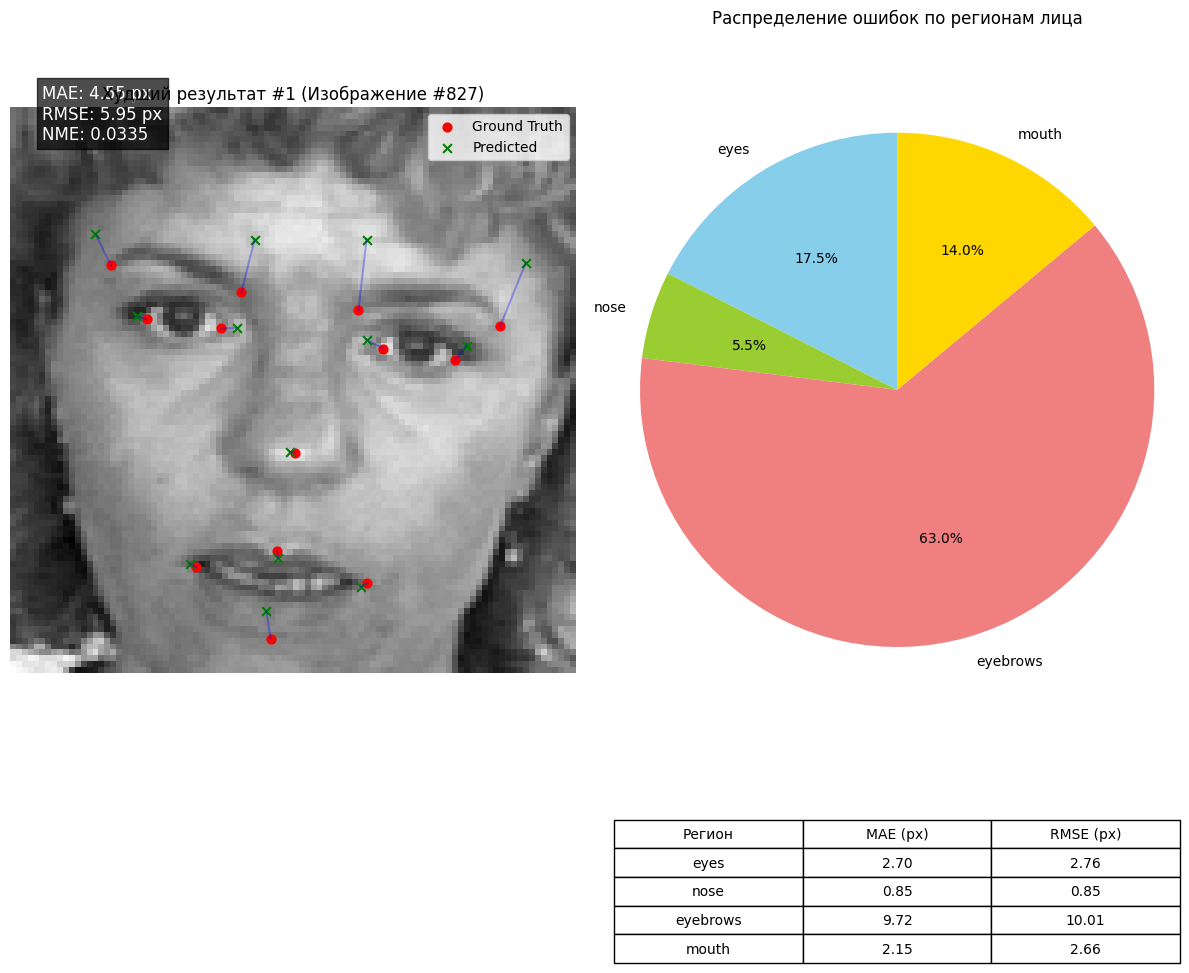

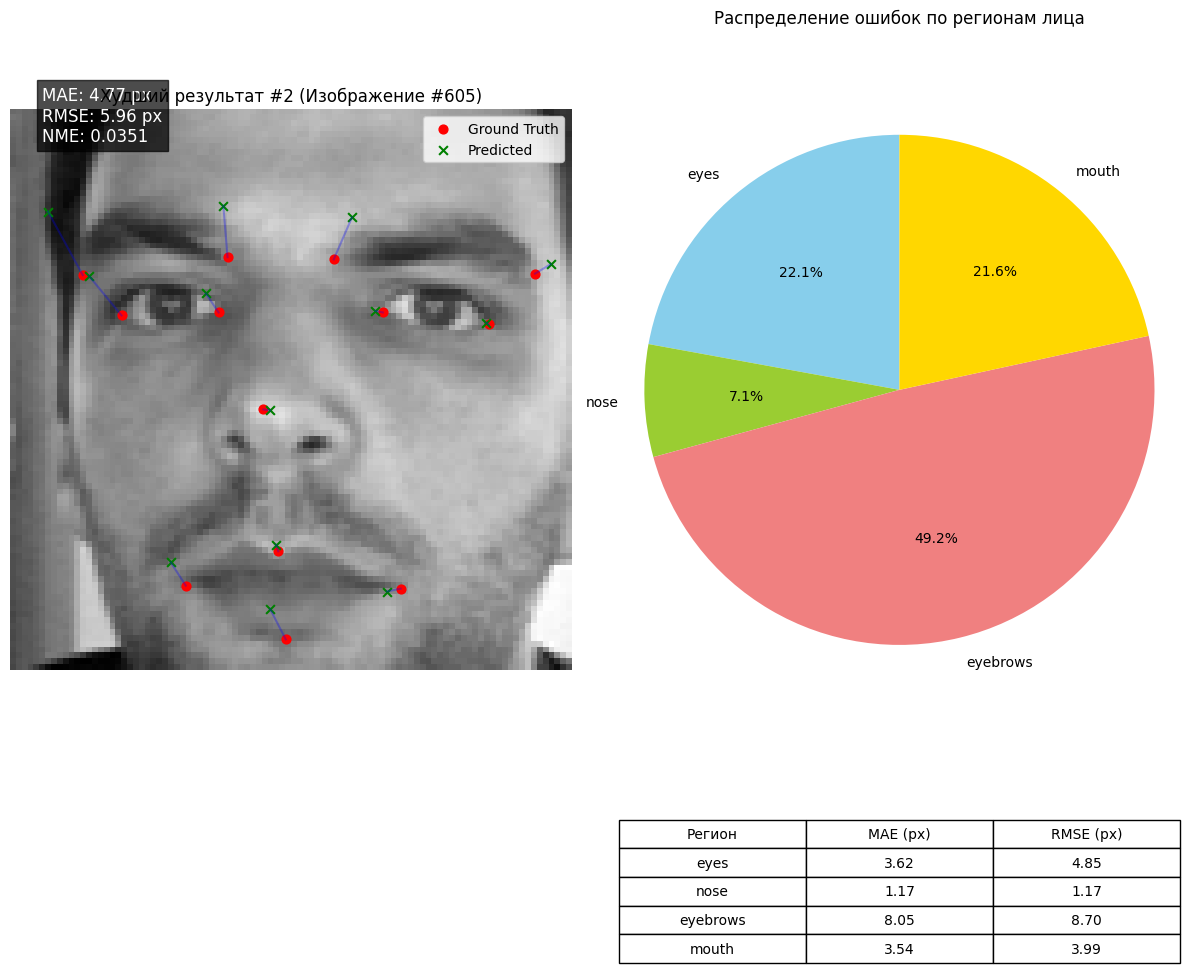

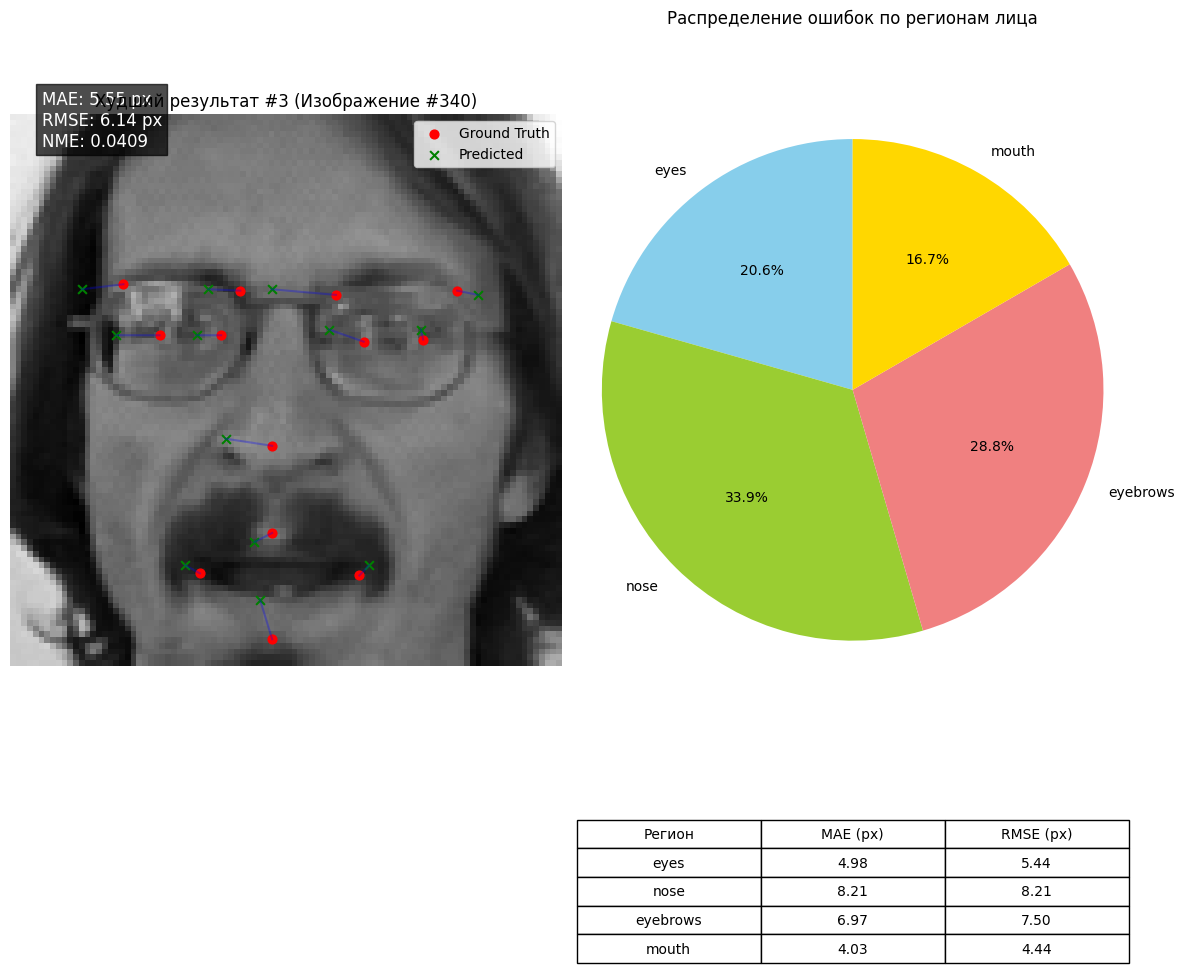

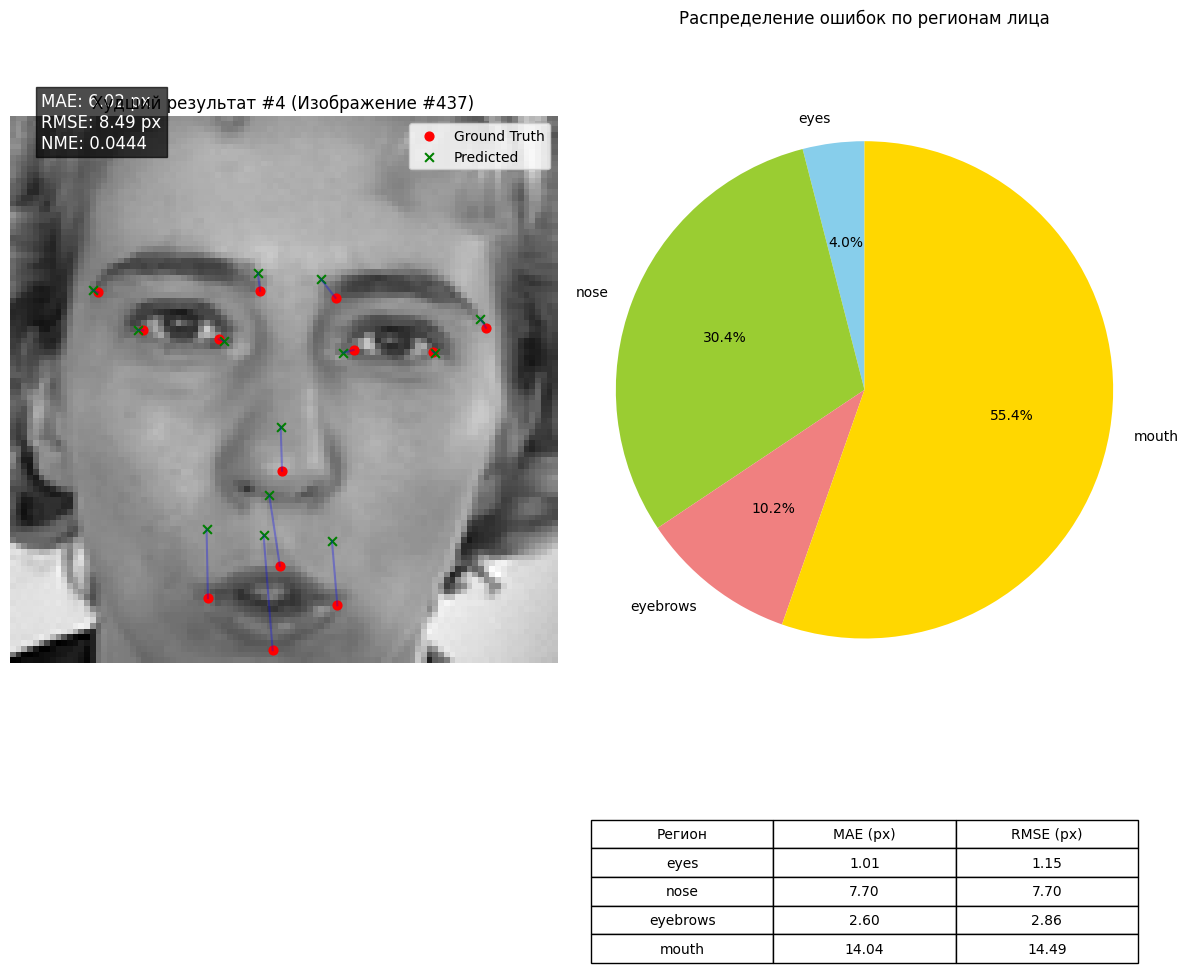

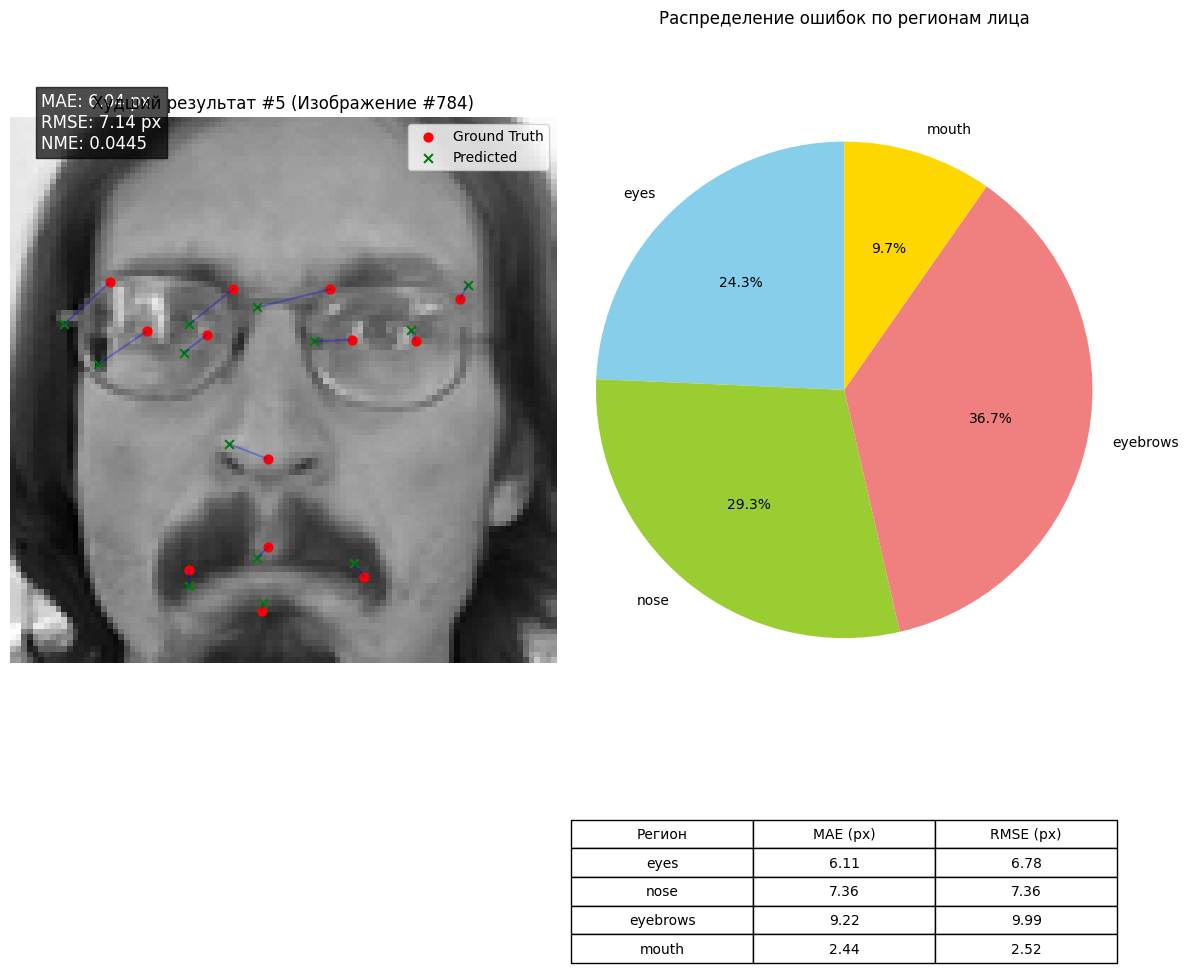

In [20]:
def visualize_result(result, title):
    """Визуализирует результат детектирования с дополнительной информацией о регионах"""
    plt.figure(figsize=(12, 10))
    
    # Основное изображение
    plt.subplot(1, 2, 1)
    plt.imshow(result['image'], cmap='gray')
    
    # Ground Truth точки (красные)
    plt.scatter(result['gt_points'][2:, 0],  # Исключаем центры глаз
                result['gt_points'][2:, 1], 
                c='r', s=40, label='Ground Truth')
    
    # Предсказанные точки (зеленые)
    plt.scatter(result['pred_points'][2:, 0],  # Исключаем центры глаз
                result['pred_points'][2:, 1], 
                c='g', s=40, marker='x', label='Predicted')
    
    # Соединяем соответствующие точки линиями (без центров глаз и кончика носа)
    for i in range(2, len(result['gt_points'])):  # Начинаем с индекса 2
        plt.plot([result['gt_points'][i, 0], result['pred_points'][i, 0]],
                 [result['gt_points'][i, 1], result['pred_points'][i, 1]],
                 'b-', alpha=0.3)
    
    # Добавляем метрики
    metrics_text = (f"MAE: {result['metrics']['MAE']:.2f} px\n"
                    f"RMSE: {result['metrics']['RMSE']:.2f} px\n"
                    f"NME: {result['metrics']['NME']:.4f}")
    plt.text(5, 5, metrics_text, bbox=dict(facecolor='black', alpha=0.7),
             color='white', fontsize=12)
    
    plt.title(title)
    plt.legend(loc='upper right')
    plt.axis('off')
    
    # Ошибки по регионам 
    plt.subplot(1, 2, 2)
    
    # Визуализация ошибок по регионам
    regions = ['eyes', 'nose', 'eyebrows', 'mouth']
    region_errors = [result['metrics']['Region_Error'][region]['MAE'] for region in regions]
    
    # Круговая диаграмма
    plt.pie(region_errors, labels=regions, autopct='%1.1f%%', 
            startangle=90, colors=['skyblue', 'yellowgreen', 'lightcoral', 'gold'])
    plt.axis('equal')
    plt.title('Распределение ошибок по регионам лица')
    
    # Таблица с детальными ошибками
    table_data = []
    for region in regions:
        mae = result['metrics']['Region_Error'][region]['MAE']
        rmse = result['metrics']['Region_Error'][region]['RMSE']
        table_data.append([region, f"{mae:.2f}", f"{rmse:.2f}"])
    
    # Добавляем таблицу ниже круговой диаграммы
    column_labels = ['Регион', 'MAE (px)', 'RMSE (px)']
    table = plt.table(cellText=table_data, colLabels=column_labels, 
                      loc='bottom', cellLoc='center', bbox=[0.0, -0.3, 1, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    
    plt.tight_layout()
    plt.show()



# Визуализируем 3 лучших результата
print("=== Лучшие результаты детектирования ===")
for i, result in enumerate(results_sorted[:5]):
    visualize_result(result, f"Лучший результат #{i+1} (Изображение #{result['index']})")

# Визуализируем 3 худших результата
print("\n=== Худшие результаты детектирования ===")
for i, result in enumerate(results_sorted[-5:]):
    visualize_result(result, f"Худший результат #{i+1} (Изображение #{result['index']})")


## Средние ошибки по регионам лица (MAE) по всему датасету

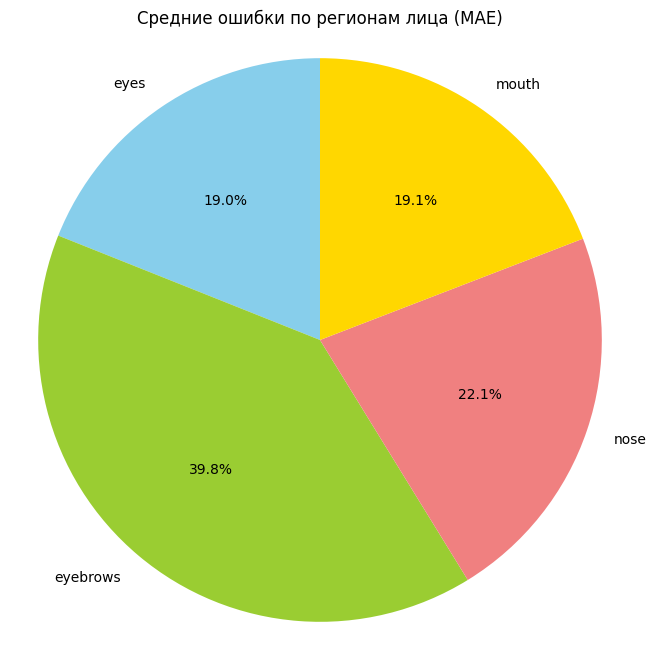

In [16]:
import matplotlib.pyplot as plt

# Список регионов
regions = ['eyes', 'eyebrows', 'nose', 'mouth']

# Словарь для хранения ошибок по регионам
region_errors_all = {region: [] for region in regions}

# Сбор данных ошибок по регионам из results_sorted
for result in results_sorted:
    for region in regions:
        region_errors_all[region].append(result['metrics']['Region_Error'][region]['MAE'])

# Рассчитываем средние ошибки для каждого региона
average_region_errors = {region: sum(region_errors_all[region]) / len(region_errors_all[region]) for region in regions}

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(average_region_errors.values(), labels=average_region_errors.keys(), autopct='%1.1f%%', 
        startangle=90, colors=['skyblue', 'yellowgreen', 'lightcoral', 'gold'])
plt.axis('equal')  # Убедимся, что круг не искажен
plt.title('Средние ошибки по регионам лица (MAE)')
plt.show()



## Подробнее посмотрим на изорбражение с сильным искажением точек(более 5 пикселей)

Найдено 375 изображений с ошибками более 10 пикселей


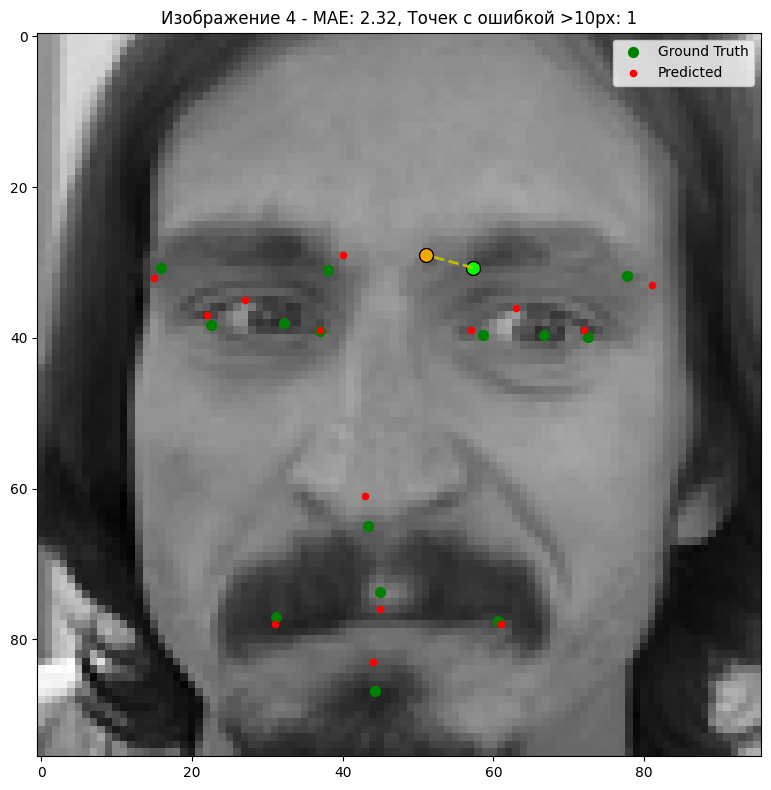

Изображение 4 - Детали ошибок:
  Точка 6: ошибка 6.47 пикселей


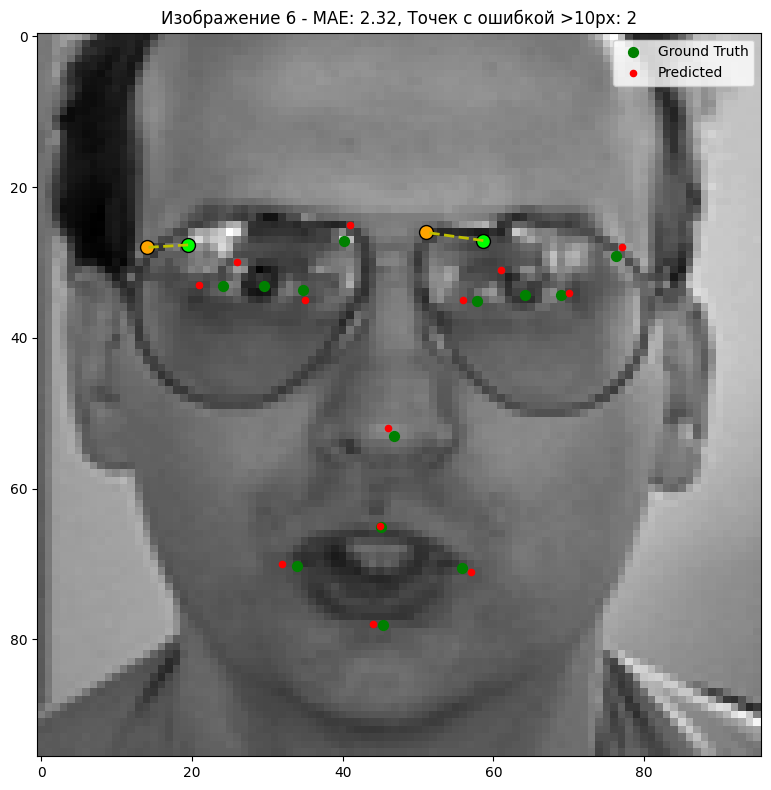

Изображение 6 - Детали ошибок:
  Точка 6: ошибка 7.74 пикселей
  Точка 9: ошибка 5.51 пикселей


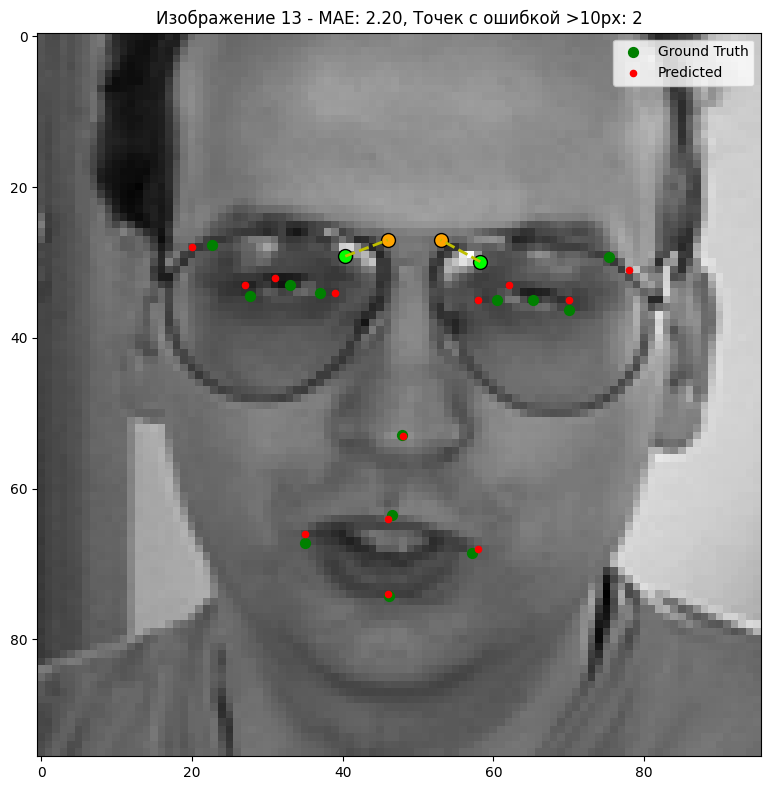

Изображение 13 - Детали ошибок:
  Точка 6: ошибка 6.00 пикселей
  Точка 8: ошибка 6.06 пикселей


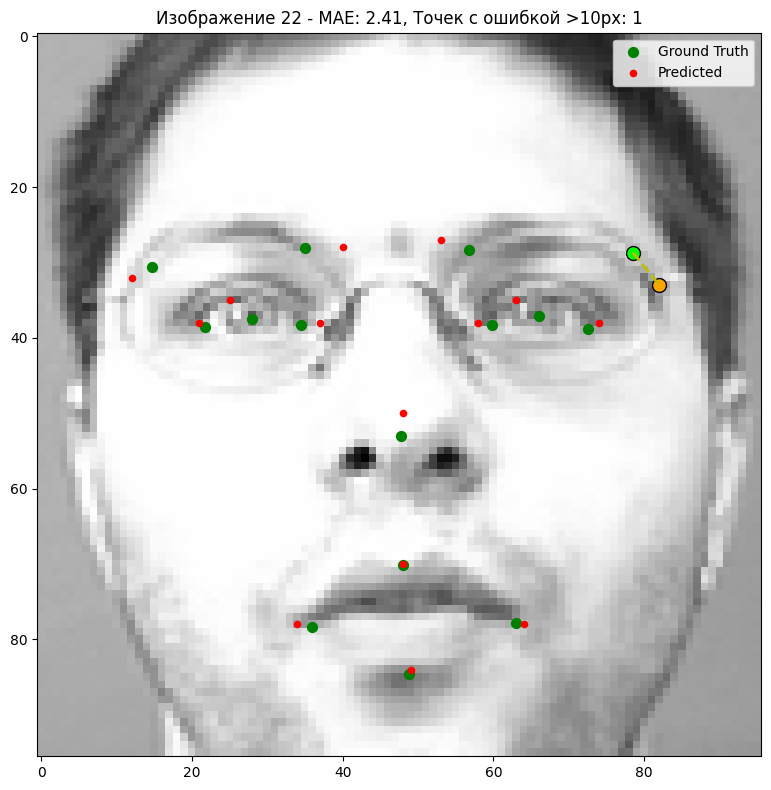

Изображение 22 - Детали ошибок:
  Точка 7: ошибка 5.55 пикселей


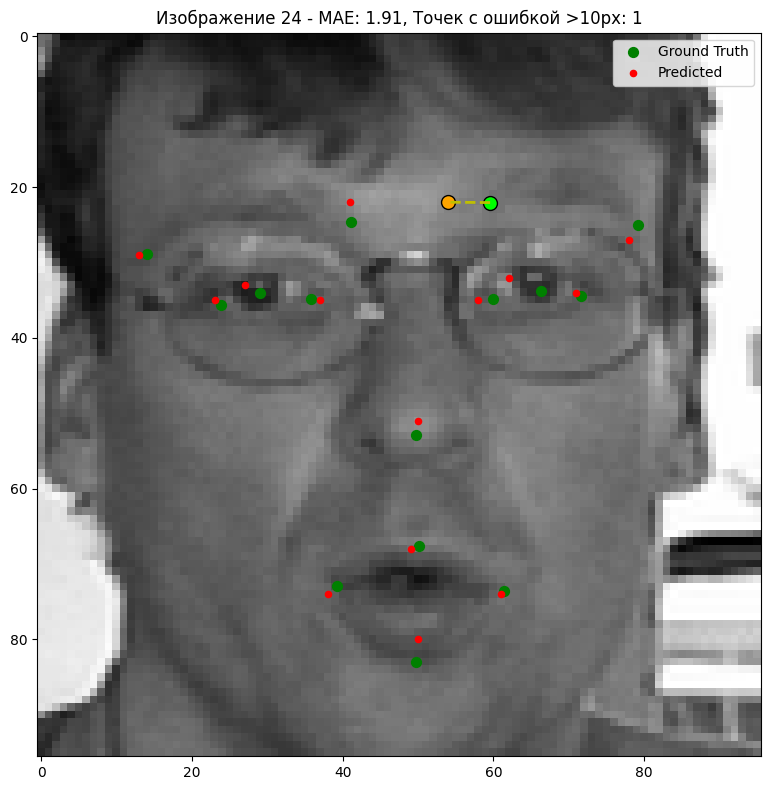

Изображение 24 - Детали ошибок:
  Точка 6: ошибка 5.56 пикселей


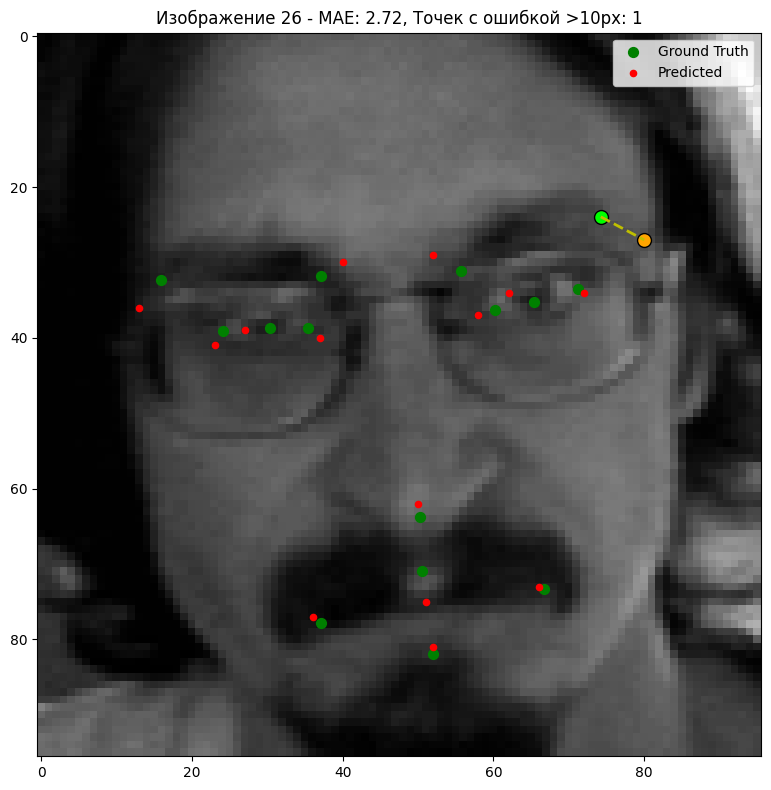

Изображение 26 - Детали ошибок:
  Точка 7: ошибка 6.52 пикселей


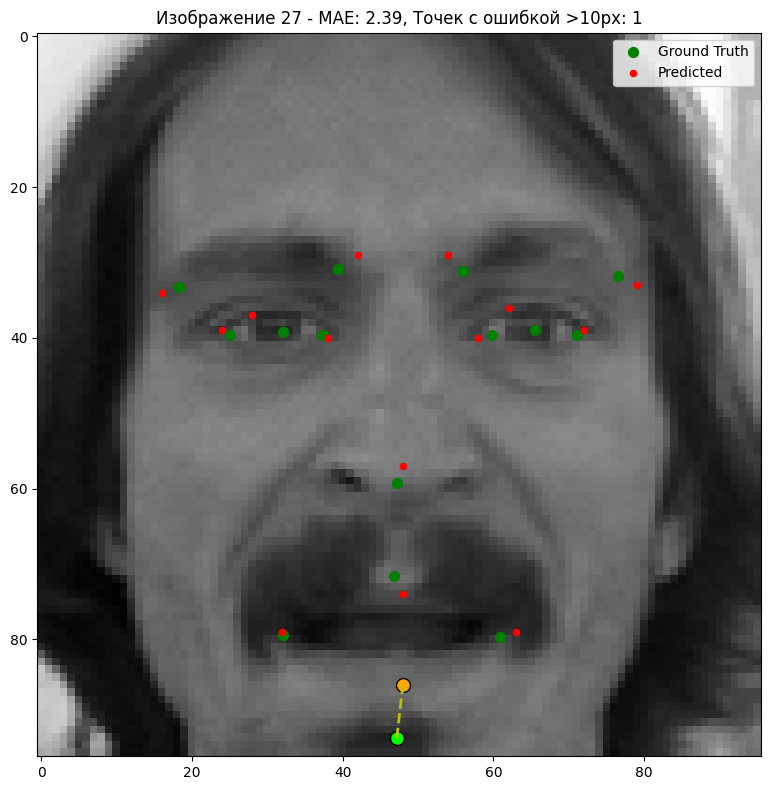

Изображение 27 - Детали ошибок:
  Точка 14: ошибка 7.11 пикселей


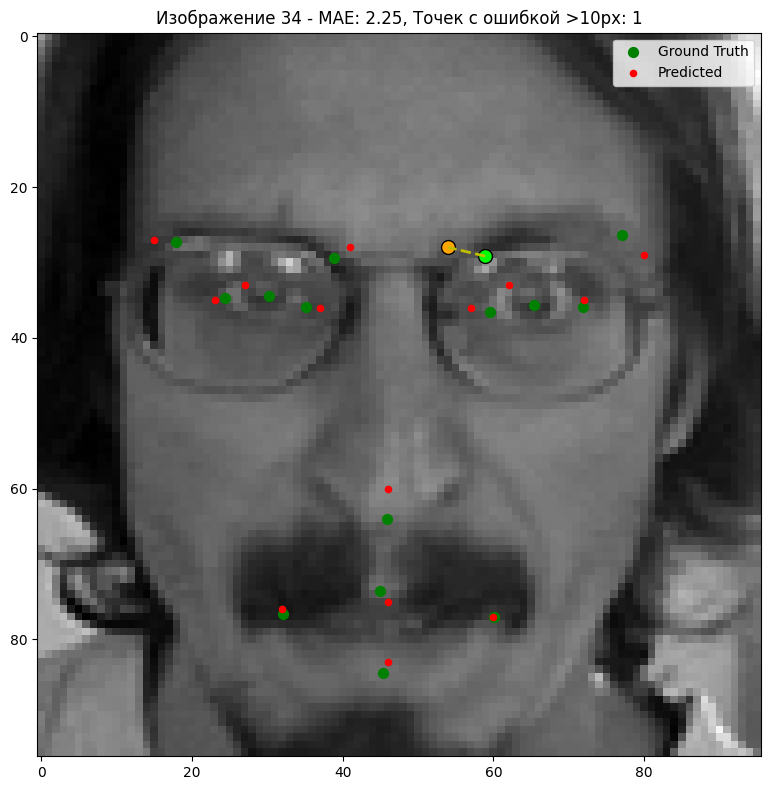

Изображение 34 - Детали ошибок:
  Точка 6: ошибка 5.03 пикселей


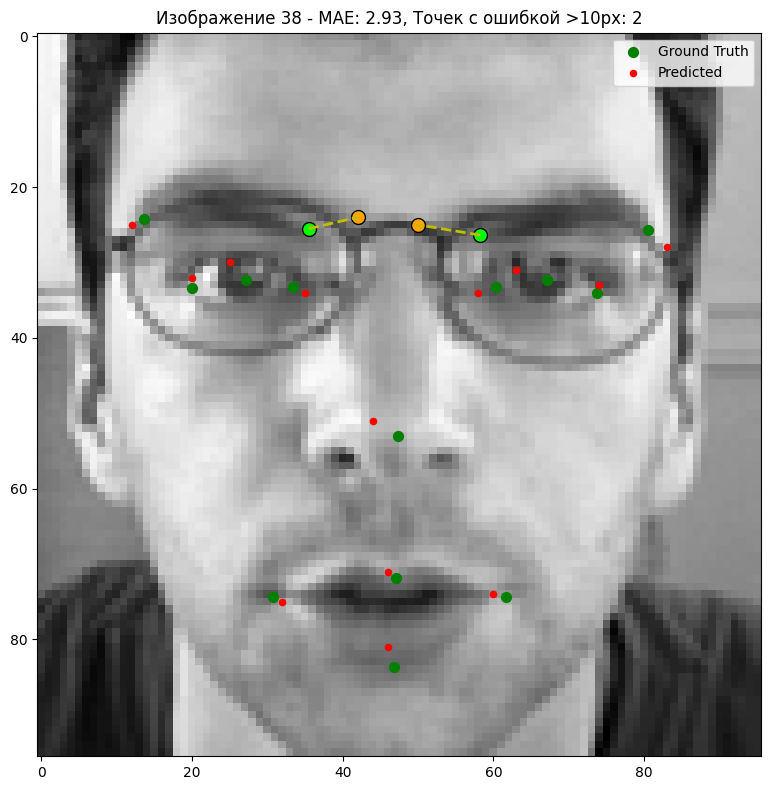

Изображение 38 - Детали ошибок:
  Точка 6: ошибка 8.36 пикселей
  Точка 8: ошибка 6.67 пикселей


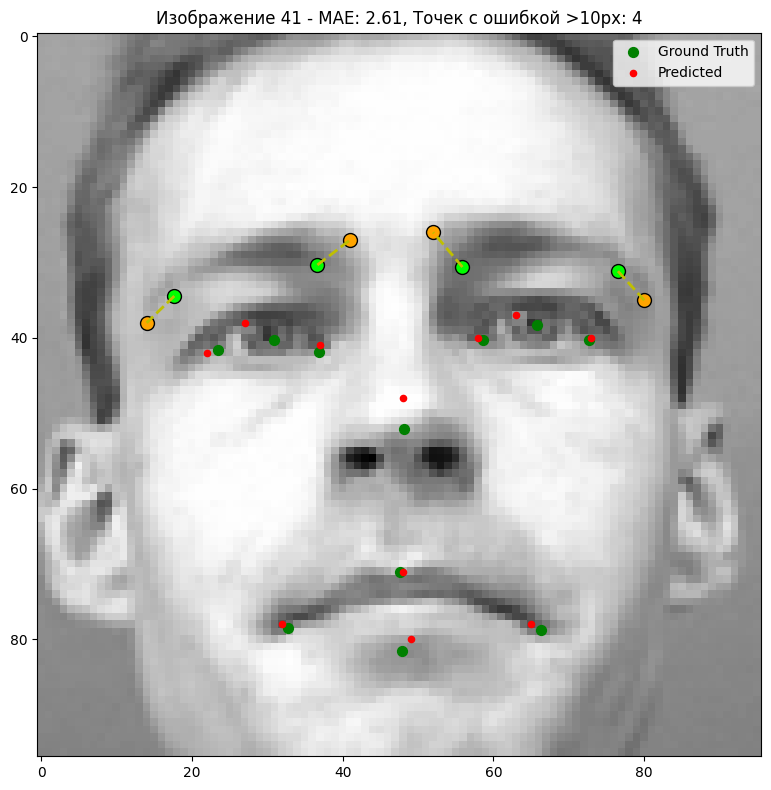

Изображение 41 - Детали ошибок:
  Точка 6: ошибка 6.03 пикселей
  Точка 7: ошибка 5.19 пикселей
  Точка 8: ошибка 5.48 пикселей
  Точка 9: ошибка 5.10 пикселей


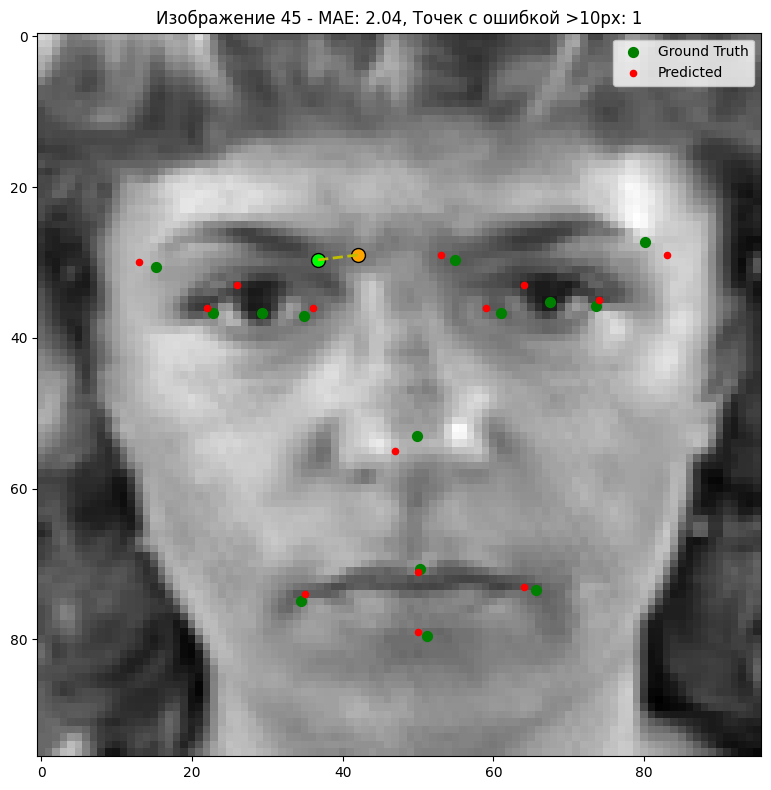

Изображение 45 - Детали ошибок:
  Точка 8: ошибка 5.30 пикселей


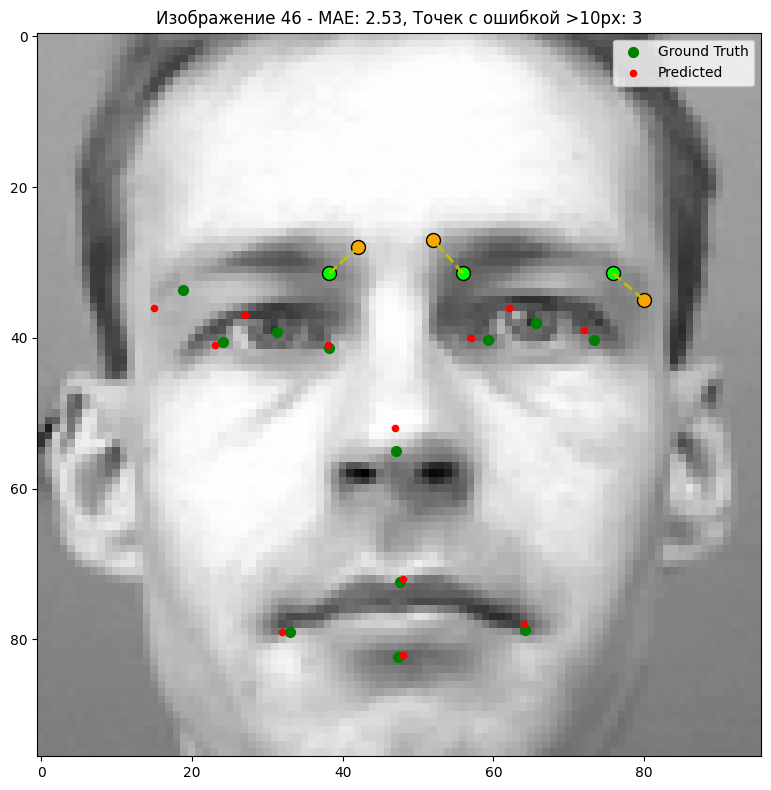

Изображение 46 - Детали ошибок:
  Точка 6: ошибка 5.93 пикселей
  Точка 7: ошибка 5.46 пикселей
  Точка 8: ошибка 5.10 пикселей


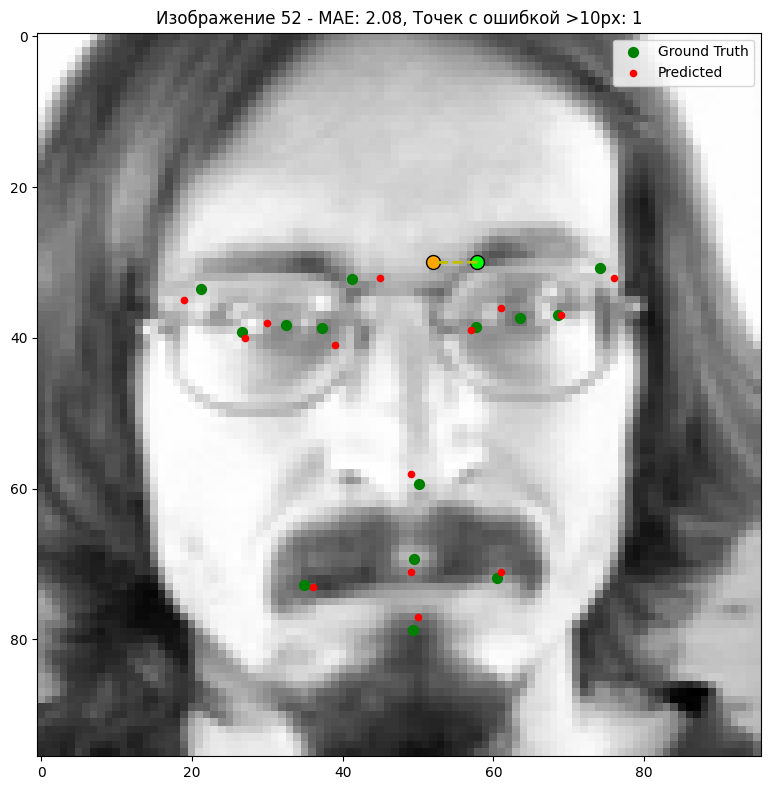

Изображение 52 - Детали ошибок:
  Точка 6: ошибка 5.87 пикселей


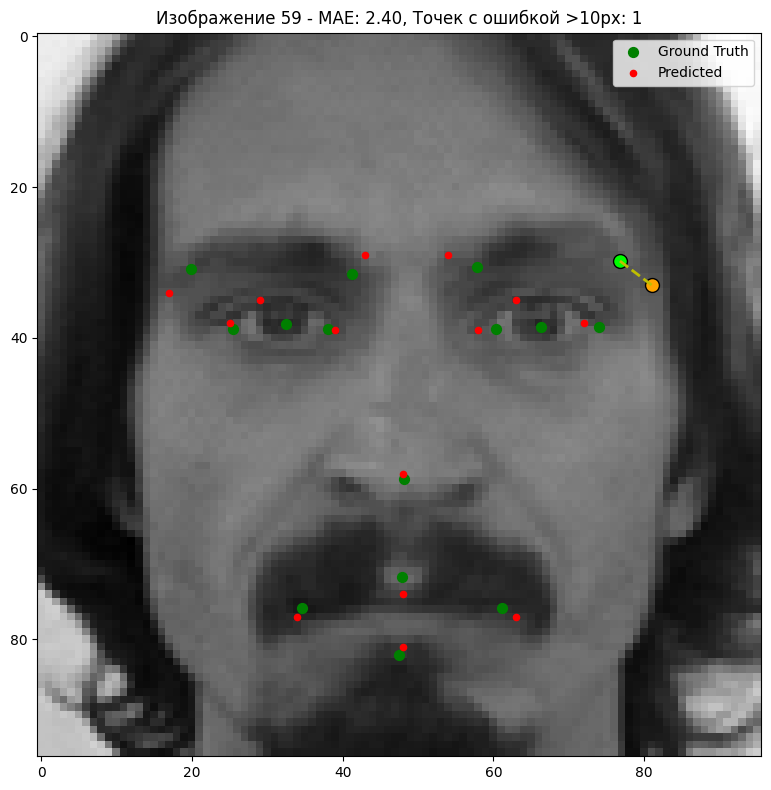

Изображение 59 - Детали ошибок:
  Точка 7: ошибка 5.29 пикселей


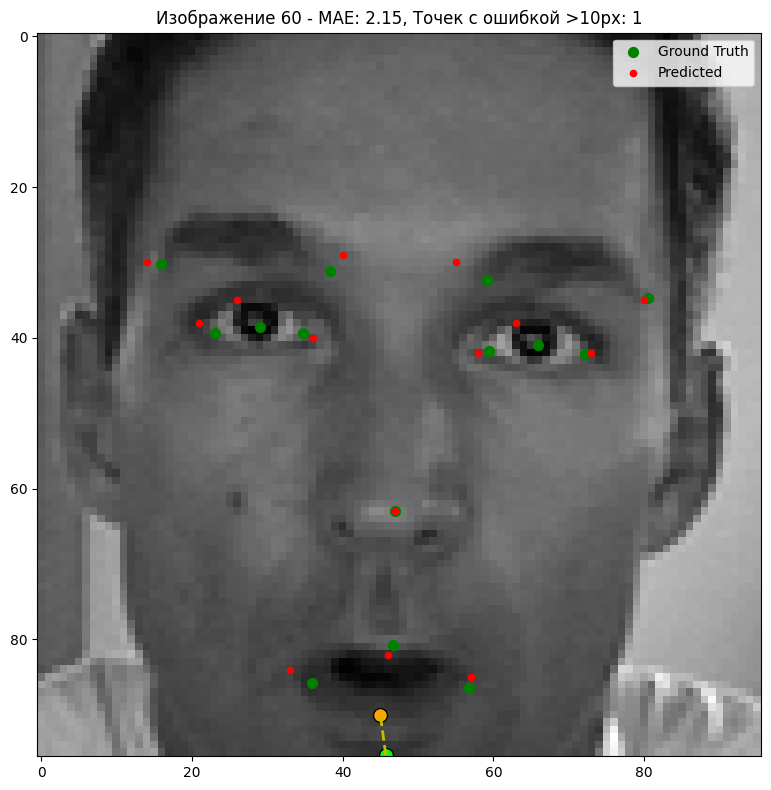

Изображение 60 - Детали ошибок:
  Точка 14: ошибка 5.41 пикселей


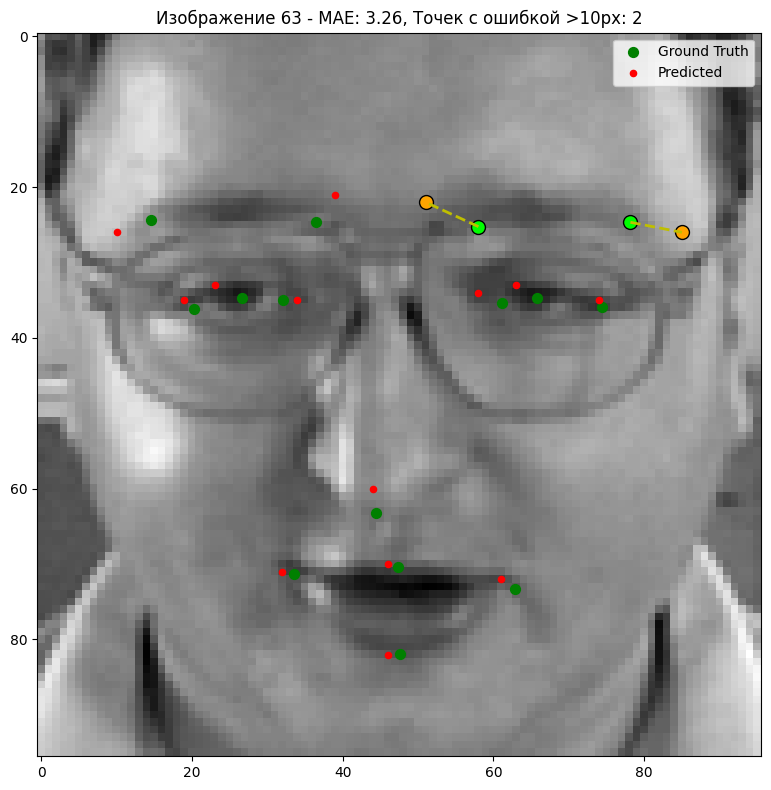

Изображение 63 - Детали ошибок:
  Точка 6: ошибка 7.73 пикселей
  Точка 7: ошибка 6.96 пикселей


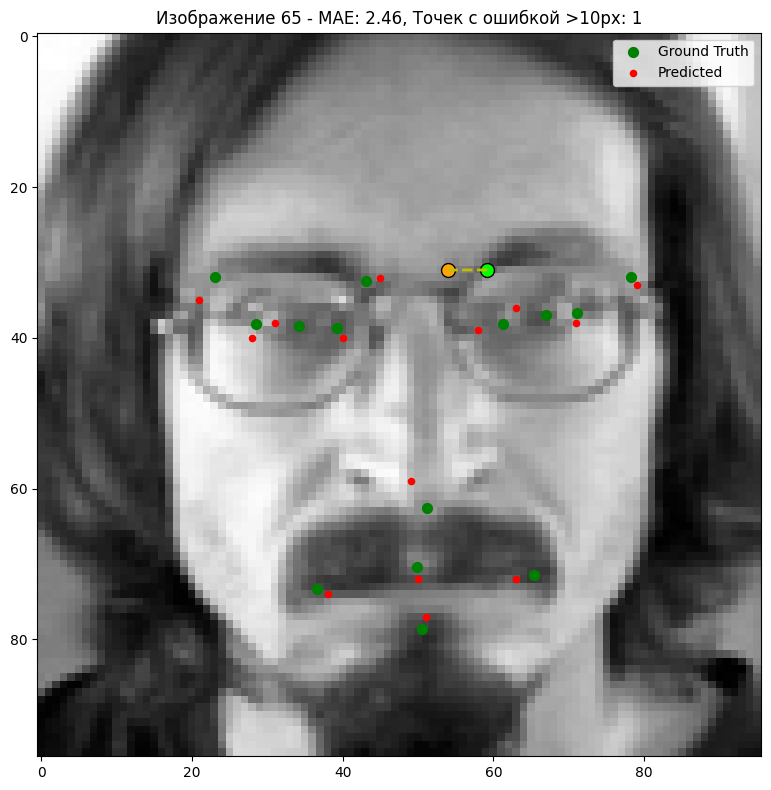

Изображение 65 - Детали ошибок:
  Точка 6: ошибка 5.18 пикселей


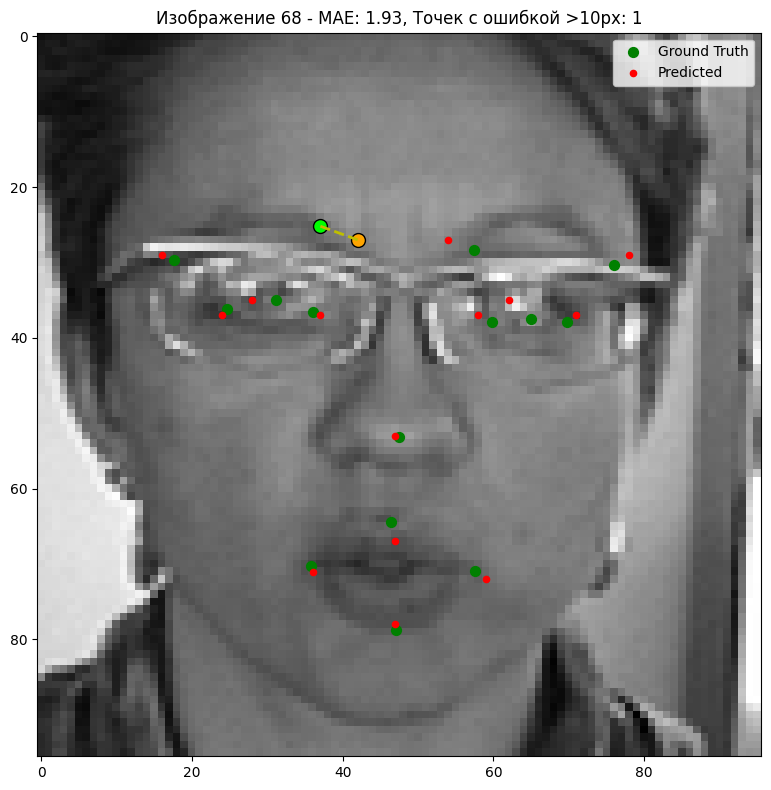

Изображение 68 - Детали ошибок:
  Точка 8: ошибка 5.27 пикселей


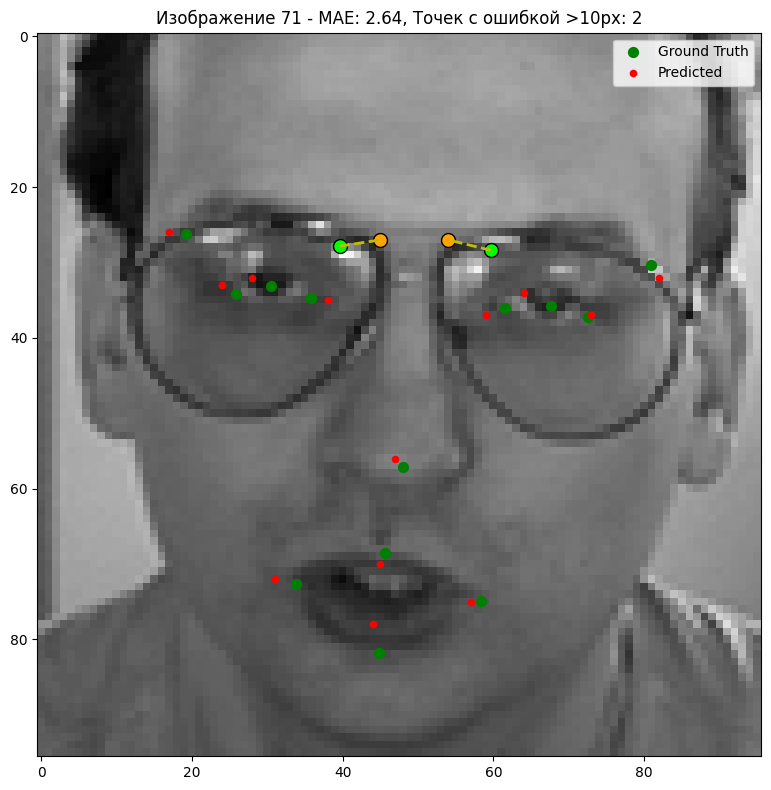

Изображение 71 - Детали ошибок:
  Точка 6: ошибка 5.84 пикселей
  Точка 8: ошибка 5.47 пикселей


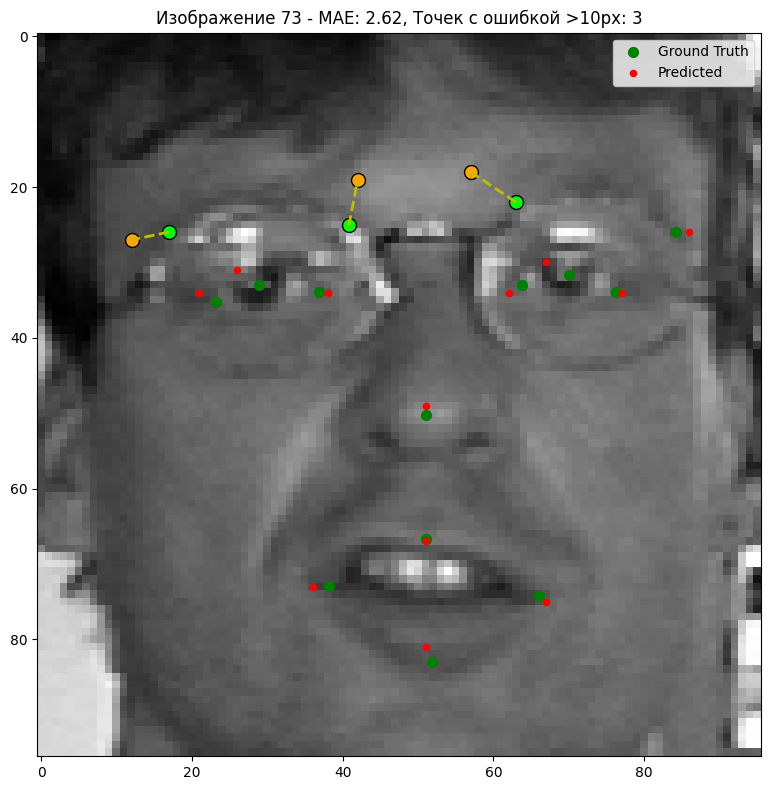

Изображение 73 - Детали ошибок:
  Точка 6: ошибка 7.16 пикселей
  Точка 8: ошибка 6.19 пикселей
  Точка 9: ошибка 5.05 пикселей


In [17]:
# Фильтрация изображений с высокими ошибками
images_with_high_errors = []

for result in results:
    for point_idx, error in result['metrics']['Per_Point_Error'].items():
        if error > 5:
            images_with_high_errors.append(result)
            break  # Добавляем изображение один раз и переходим к следующему

print(f"Найдено {len(images_with_high_errors)} изображений с ошибками более 10 пикселей")

# Визуализация проблемных изображений
def visualize_high_error_images(high_error_results, max_images=20):
    """
    Визуализирует изображения с высокими ошибками и отмечает проблемные точки
    """
    for i, result in enumerate(high_error_results[:max_images]):
        # Создаем фигуру
        plt.figure(figsize=(12, 8))
        plt.imshow(result['image'], cmap='gray')
        
        # Находим точки с высокими ошибками
        high_error_points = []
        for point_idx, error in result['metrics']['Per_Point_Error'].items():
            if error > 5:
                high_error_points.append(int(point_idx))
        
        # Рисуем все точки
        gt_points = result['gt_points']
        pred_points = result['pred_points']
        
        # Рисуем ground truth точки
        plt.scatter(gt_points[:, 0], gt_points[:, 1], 
                   color='green', label='Ground Truth', s=50)
        
        # Рисуем предсказанные точки
        plt.scatter(pred_points[:, 0], pred_points[:, 1], 
                   color='red', label='Predicted', s=20)
        
        # Выделяем проблемные точки
        for idx in high_error_points:
            # Рисуем линии, соединяющие gt и pred для проблемных точек
            x_values = [gt_points[idx+2][0], pred_points[idx+2][0]]  # +2 из-за смещения индексов
            y_values = [gt_points[idx+2][1], pred_points[idx+2][1]]
            plt.plot(x_values, y_values, 'y--', linewidth=2)
            
            # Выделяем проблемные точки более крупным маркером
            plt.scatter(gt_points[idx+2][0], gt_points[idx+2][1], 
                       color='lime', s=100, edgecolor='black')
            plt.scatter(pred_points[idx+2][0], pred_points[idx+2][1], 
                       color='orange', s=100, edgecolor='black')
        
        plt.title(f"Изображение {result['index']} - MAE: {result['metrics']['MAE']:.2f}, " + 
                 f"Точек с ошибкой >10px: {len(high_error_points)}")
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Выводим подробную информацию о проблемных точках
        print(f"Изображение {result['index']} - Детали ошибок:")
        for idx in high_error_points:
            error = result['metrics']['Per_Point_Error'][idx]
            print(f"  Точка {idx+2}: ошибка {error:.2f} пикселей")
        print("="*50)

# Запускаем визуализацию
visualize_high_error_images(images_with_high_errors)


# Выводы
Средняя ошибка в датасете для всех областей кроме бровей не превышает 2 пикселей. На графике перцентилей видно, что не более 5% всего набора данных сталвикается с критическими ошибками

 - Ошибки позиционирования как правило сонаправлены и находятся в пределах одной анатомической области. 
    - Это может говорить о неспособности модели правильно определить области лица в некоторых случая
 - Проблемнае область *бровей* как правило не имеет четких контуров ввиду анатомических особенностей роста волос, граница наружного края как правило может быть размыта. 
    - Граница также имеет различный вид в зависимости от угла под которым сфотографировано лицо человека. 
    - Также брови вовсе могут быть скрыты под аксессуарами или волосами.
    - Это также вносит сложность и вариантивность при разметке.
    - Все это также справедливо для области глаз.

- Проблемная область кончика носа также очень вариантивна в зависимости от положения лица и освещенности. Подобные проблемы могут происходить при недостаточно репрезентативной обучающей выборке модели или проблемах аугментаций.

- График смещения показывает стабильное смещение вправо-вниз (~0.8 пикселя), что может быть скорректировано.

# 3. Работа с инструментами разметки


## Подключусб к supervisely

In [18]:
# Настройка переменных окружения для аутентификации
os.environ['SERVER_ADDRESS'] = 'https://app.supervisely.com'  # Адрес Supervisely
os.environ['API_TOKEN'] = 'NPsbvEjZbQdxsqCXZzmA1Mg372CXnN8pTaeVdvtG76mzHXbJIBiJ3rPxwlbMAauzpo0fX1iNiRAUGQOEivacLd4aLutfop0iHmme1in8mL1TF3EDu2LNIDujJFMfBljP'  # Замените на ваш API токен

# Инициализация API
api = sly.Api.from_env()

# Проверка подключения
my_teams = api.team.get_list()
print(f"Подключено к Supervisely. Доступно команд: {len(my_teams)}")


Подключено к Supervisely. Доступно команд: 1


## Загрузка данных

In [19]:
# Создание нового проекта и датасета
workspace_id = 120647  # Укажите ID вашего рабочего пространства
project_name = "Face Keypoints Correction"
dataset_name = "Model Predictions"

# Создание проекта
project = api.project.create(workspace_id=workspace_id, name=project_name)

# Создание датасета
dataset = api.dataset.create(project.id, name=dataset_name)

# Определение классов для точек лица
keypoint_classes = [
    sly.ObjClass('left_eye_inner_corner', sly.Point),
    sly.ObjClass('left_eye_outer_corner', sly.Point),
    sly.ObjClass('right_eye_inner_corner', sly.Point),
    sly.ObjClass('right_eye_outer_corner', sly.Point),
    sly.ObjClass('left_eyebrow_inner_end', sly.Point),
    sly.ObjClass('left_eyebrow_outer_end', sly.Point),
    sly.ObjClass('right_eyebrow_inner_end', sly.Point),
    sly.ObjClass('right_eyebrow_outer_end', sly.Point),
    sly.ObjClass('nose_tip', sly.Point),
    sly.ObjClass('mouth_left_corner', sly.Point),
    sly.ObjClass('mouth_right_corner', sly.Point),
    sly.ObjClass('mouth_center_top_lip', sly.Point),
    sly.ObjClass('mouth_center_bottom_lip', sly.Point)
]

# Создание метаданных проекта
meta = sly.ProjectMeta(obj_classes=keypoint_classes)
api.project.update_meta(project.id, meta)

MAPPING = {
    'left_eye_inner_corner': 42,  # Внутренний угол левого глаза
    'left_eye_outer_corner': 45,  # Внешний угол левого глаза
    'right_eye_inner_corner': 39, # Внутренний угол правого глаза
    'right_eye_outer_corner': 36, # Внешний угол правого глаза
    'left_eyebrow_inner_end': 22, # Внутренний конец левой брови
    'left_eyebrow_outer_end': 26, # Внешний конец левой брови
    'right_eyebrow_inner_end': 21,# Внутренний конец правой брови
    'right_eyebrow_outer_end': 17,# Внешний конец правой брови
    'nose_tip': 30,               # Кончик носа
    'mouth_left_corner': 54,      # Левый уголок рта
    'mouth_right_corner': 48,     # Правый уголок рта
    'mouth_center_top_lip': 51,   # Центр верхней губы
    'mouth_center_bottom_lip': 57 # Центр нижней губы
}

# Загрузка изображений и предсказаний в Supervisely
# Используем 10 изображений из худших результатов
for i, result in enumerate(results_sorted[-10:]):
    if i >= 10:  # Ограничиваем количество загружаемых изображений
        break
        
    # Получаем изображение и преобразуем его
    image = result['image']
    
    # Сохраняем изображение во временный файл
    temp_img_path = f"temp_image_{i}.jpg"
    plt.imsave(temp_img_path, image, cmap='gray')
    
    # Загружаем изображение в Supervisely
    img_info = api.image.upload_path(dataset.id, 
                                    name=f"face_{result['index']}.jpg", 
                                    path=temp_img_path)
    
    # Создаем аннотации для ключевых точек
    labels = []
    for j, (kp_name, kp_coord) in enumerate(zip(MAPPING.keys(), result['pred_points'])):
        x, y = kp_coord
        # Создаем точечную метку для каждой ключевой точки
        point = sly.Point(y, x)  # Важно: Supervisely использует (y, x) координаты
        label = sly.Label(point, meta.get_obj_class(kp_name))
        labels.append(label)
    
    # Создаем аннотацию со всеми метками
    ann = sly.Annotation(img_size=(image.shape[0], image.shape[1]), labels=labels)
    
    # Загружаем аннотацию в Supervisely
    api.annotation.upload_ann(img_info.id, ann)
    
    # Удаляем временный файл
    os.remove(temp_img_path)

print(f"Загружено {min(10, len(results_sorted))} изображений и аннотаций в Supervisely")


{"message": "Request has failed. This may be due to connection problems or invalid requests. ", "reason": "{\"error\":\"projects already exists\",\"details\":{\"type\":\"NONUNIQUE\",\"errors\":[{\"name\":\"Face Keypoints Correction\",\"id\":340964,\"message\":\"Project with name \\\"Face Keypoints Correction\\\" already exists\"}]}}", "status_code": 400, "url": "https://app.supervisely.com/public/api/v3/projects.add", "timestamp": "2025-03-31T12:01:54.339Z", "level": "warn"}


HTTPError: 400 Client Error: Bad Request for url: https://app.supervisely.com/public/api/v3/projects.add ({"error":"projects already exists","details":{"type":"NONUNIQUE","errors":[{"name":"Face Keypoints Correction","id":340964,"message":"Project with name \"Face Keypoints Correction\" already exists"}]}})

![Screenshot 2025-03-31 at 13.35.33.png](<attachment:Screenshot 2025-03-31 at 13.35.33.png>)

https://app.supervisely.com/projects/340964/datasets/1033905
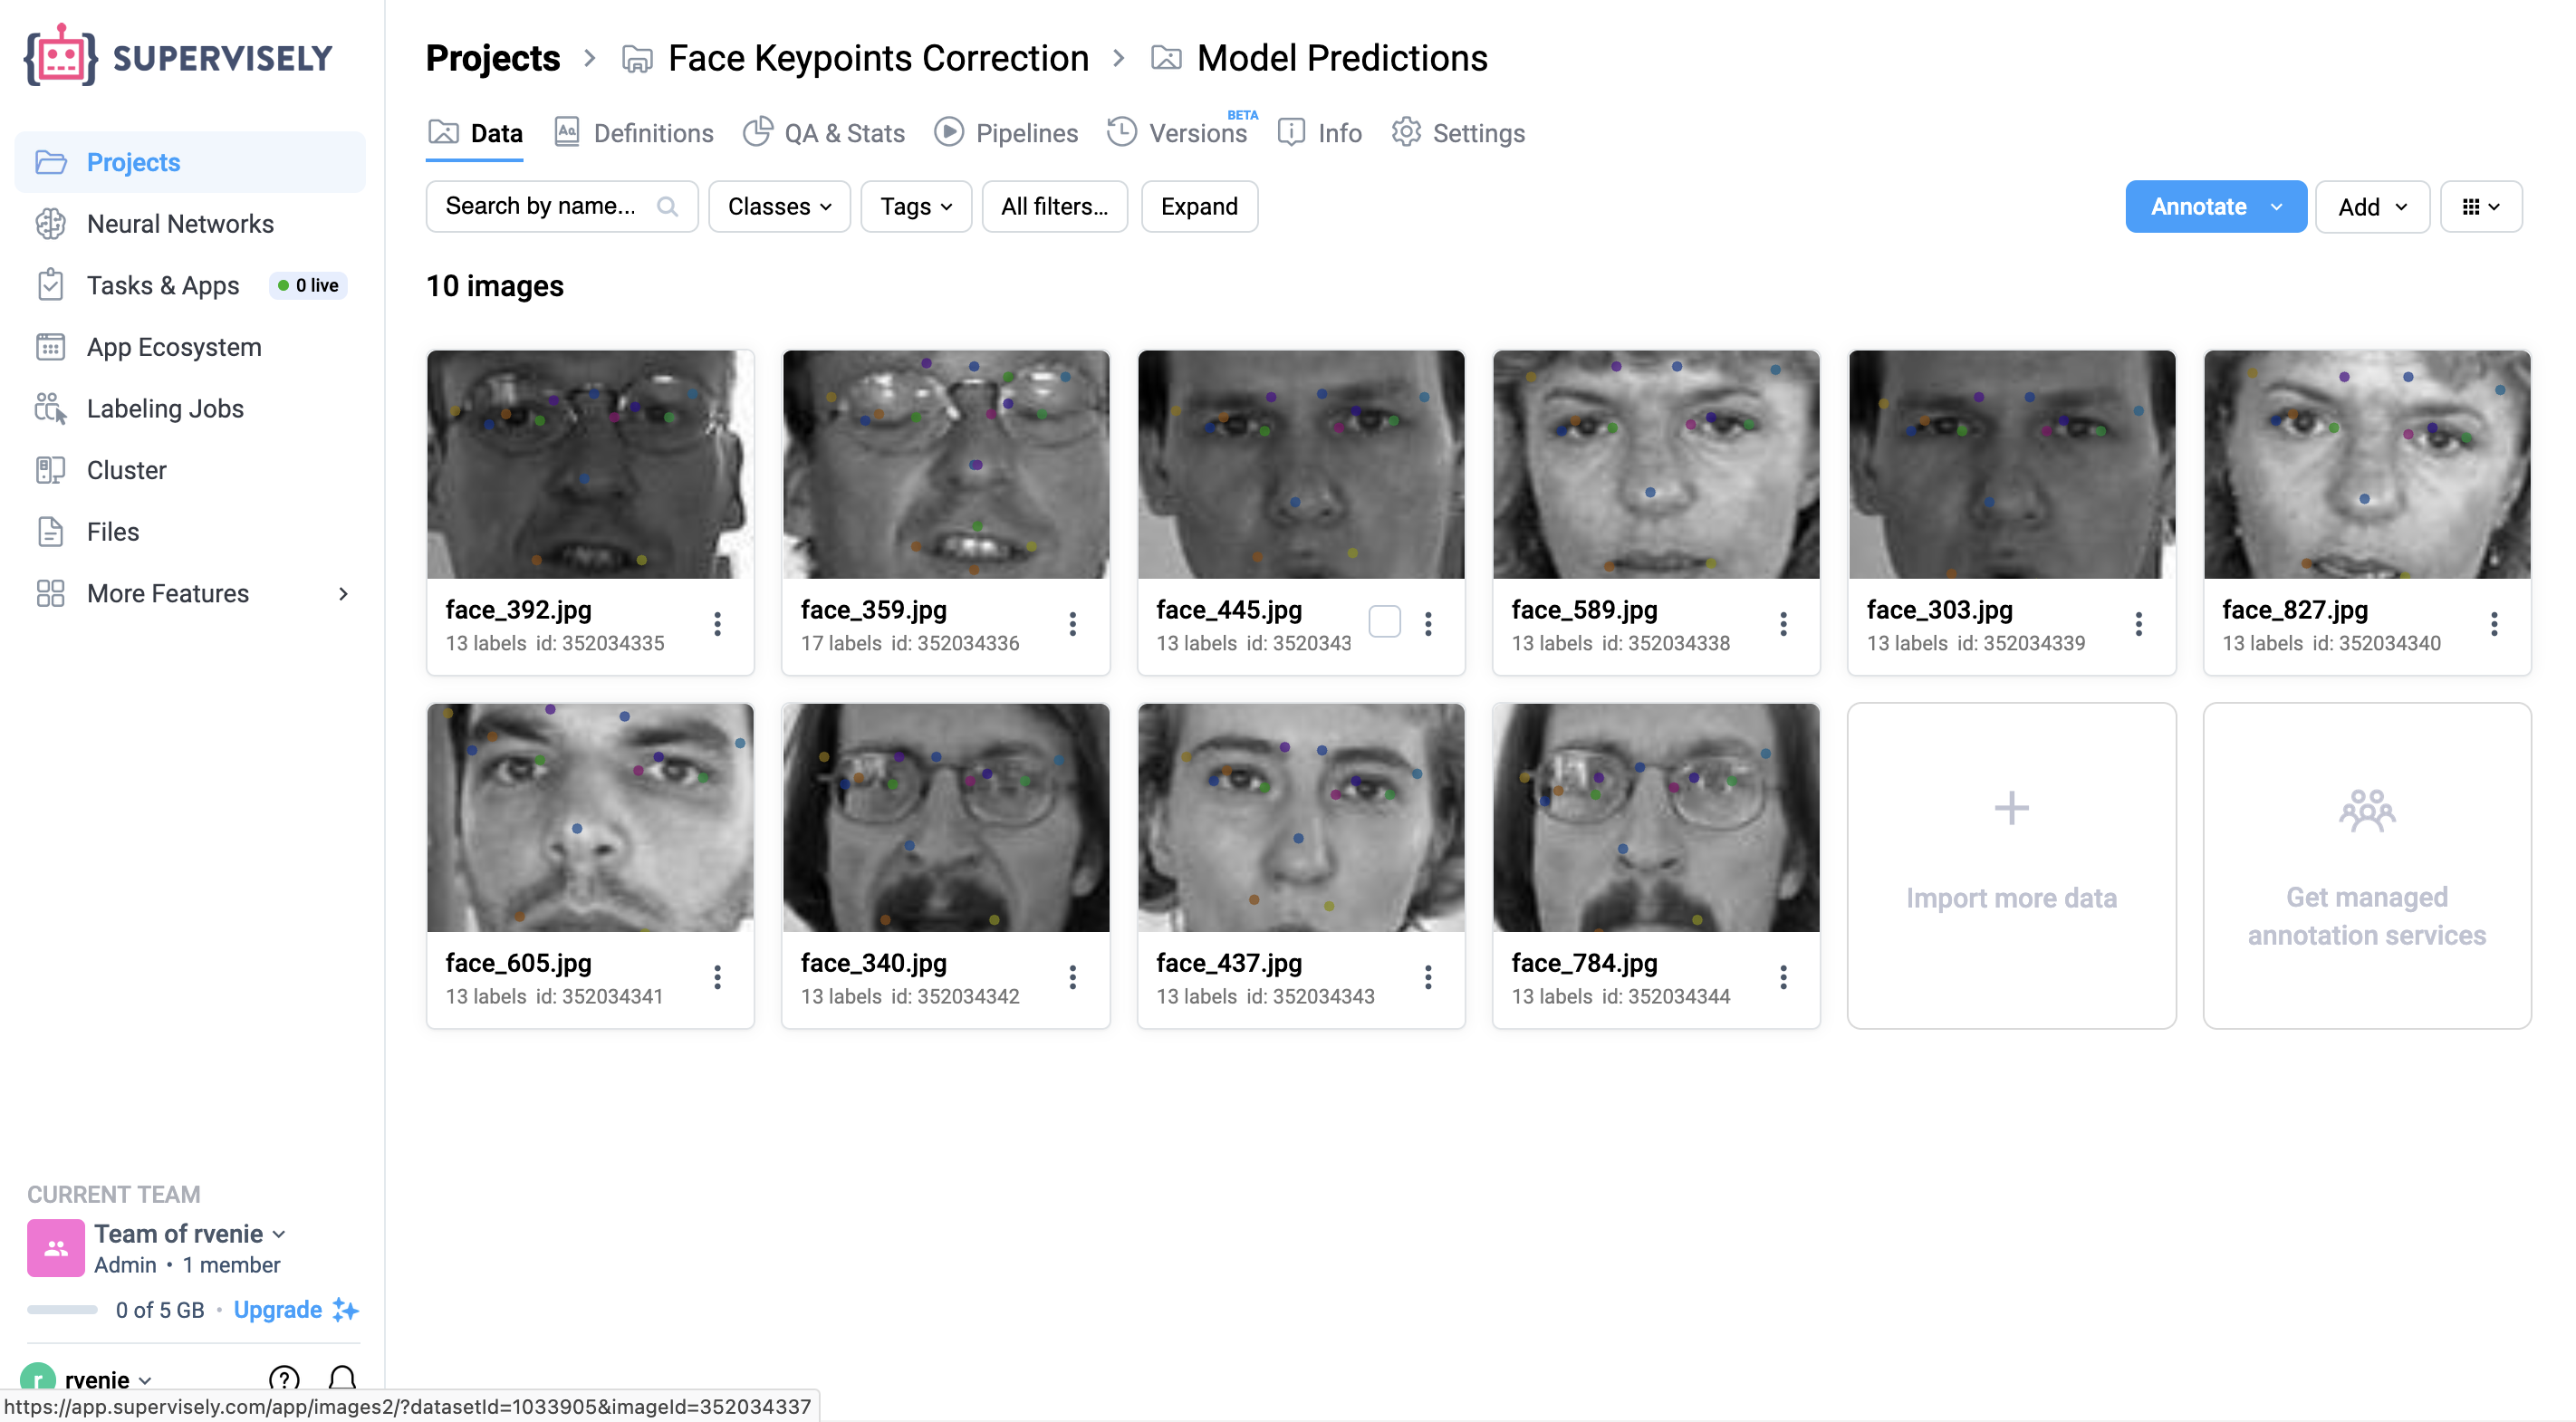

## Алгоритм доразметки

Что конкретно и как

> Этап 1: Предварительная обработка
- Применить автоматическую разметку с помощью модели для всего набора данных
- Отсортировать результаты по величине ошибки (MAE, RMSE или NME)
- Разделить изображения на группы по качеству предсказаний:
    - Хорошие (MAE < 3 пикселя)
    - Средние (MAE 3-7 пикселей)
    - Плохие (MAE > 7 пикселей)

> Этап 2: Приоритизация доразметки
- Начать с исправления точек в областях с наибольшими ошибками (брови, кончик носа)
- Для каждого изображения сфокусироваться сначала на точках с наибольшим отклонением

> Этап 3: Процесс доразметки
- Загрузить изображение с предварительной разметкой модели
- Визуализировать текущие метки и их отклонения
- Корректировать позиции ключевых точек, начиная с областей с наибольшими ошибками:
    - Брови → Нос → Рот → Глаза
    
> Этап 4: Валидация
- Проверять согласованность разметки через случайную выборку
- Применять проверки на анатомическую правдоподобность (например, симметрию)


# Замерить скорость разметки
 - Оценить скорость разметки с нуля
 - Оценить время доразметки результатов работы модели


> Разметка с нуля:
- Для разметки одной фотографии на 15 точек потребуется от 30 секунд до 1,5 минут.
- *Грубо* говоря набора из 1000 изображений потребуется:
    - 1000 изображений * 1.5 минуты = 1500 минут ≈ 25 часов чистого времени
    - С учетом перерывов и проверки качества ≈ 30 часов работы

> Доразметка на основе предсказаний модели:
- В нашем случае модель неплохо справляется для большинства фотографий (МАЕ 1-5 пикселей)
- Корректировка точек как правило требуется в рамках одного-двух анатомического региона, что несколько удобнее для разметчика
- Всего фотографий с ошибкой более 5 пикселей 375 - что меньше 40% от общего числа фотографий
- Из предположения, что более 50% точек в этих изоюражениях стоят на своих местах, мы уменьшим время разметки в 2 раза
- Итого с учетом меньшего кол-ва областей и обьема работ:
    - Доразметка одного иозобраения 15-45 секунд
    - Всего ~400 изображений * 45 секунд = 300 минут = 5 часов.
    - Учтем перерывы и другие корректировки = 8 часов.
> Методом доразметки мы экономим больше *2 рабочий дней* разметчиков.

> Предложения по ускорению:
- Обучение разметчиков горячим клавишам
- Инкрементальное обучение: после доразметки части данных переобучать модель на исправленных примерах, это может улучшить качество предсказаний для оставшихся изображений